# Nice to Meat You: An Analysis on Meat Consumption

## Introduction
This notebook contains all our analysis for the Dunnhumby dataset. This analysis focuses on meat consumption and its relation with the consumers' socio-economic characteristics, with other products' consumption and with the time of the year.

In the first part, we explore the dataset. To do so, we first perform exloratory analysis (size, missing, values, ...) and then create new colums and tables necessary to conduct our analysis. Finally, we look for more specific insights that are relevant for our project. Finally, we expand our analysis by combining several datasets.

The second part goes deeper in the analysis. We start by analysing the links between socio-economic characteristics and the meat/vegetables consumption. The first observations are made for one characteristic at a time and then a sharper analysis is made combining some characteristics two by two.
Thereafter, we have decided to conduct a time-dependant analysis on the meat and vegetable consumption. The objective is to answer if they are some products or meat categories more consumed during given seasons or months. 
Finally, we analyze which products are the most consumed for different categories of households. We start by comparing extreme meat consumers with extreme vegetables consumers then the youngest category with the oldest and finally the poorest with the wealthiest. 

All these analyses form the main part of the project. Some parts may refer to the *statistics.ipynb* notebook for statistical significance and a *preprocess.ipynb* was usefull to clean the food products dataset before handling it here.

## Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
import scipy.stats
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from PIL import Image

default_figsize = (12.8, 4.8)

## Household Demographics

Exploratory analysis of the household demographics dataset.

In [2]:
df_household = pd.read_csv('dunnhumby/hh_demographic.csv', sep = ',')
df_household.head()

AGE_DESC MARITAL_STATUS_CODE INCOME_DESC HOMEOWNER_DESC      HH_COMP_DESC  \
0      65+                   A      35-49K      Homeowner  2 Adults No Kids   
1    45-54                   A      50-74K      Homeowner  2 Adults No Kids   
2    25-34                   U      25-34K        Unknown     2 Adults Kids   
3    25-34                   U      75-99K      Homeowner     2 Adults Kids   
4    45-54                   B      50-74K      Homeowner     Single Female   

  HOUSEHOLD_SIZE_DESC KID_CATEGORY_DESC  household_key  
0                   2      None/Unknown              1  
1                   2      None/Unknown              7  
2                   3                 1              8  
3                   4                 2             13  
4                   1      None/Unknown             16

In [3]:
# correct dtypes
df_household['AGE_DESC'] = pd.Categorical(df_household['AGE_DESC'].values, categories=['19-24', '25-34', '35-44', '45-54', '55-64', '65+'], ordered=True)
df_household['MARITAL_STATUS_CODE'] = df_household['MARITAL_STATUS_CODE'].astype('category')
df_household['INCOME_DESC'] = pd.Categorical(df_household['INCOME_DESC'].values, \
    categories=['Under 15K', '15-24K', '25-34K', '35-49K', '50-74K', '75-99K', '100-124K', '125-149K', '150-174K', '175-199K', '200-249K', '250K+'], \
    ordered=True)
df_household['HOMEOWNER_DESC'] =  df_household['HOMEOWNER_DESC'].astype('category')
df_household['HH_COMP_DESC'] = df_household['HH_COMP_DESC'].astype('category')
df_household['HOUSEHOLD_SIZE_DESC'] = pd.Categorical(df_household['HOUSEHOLD_SIZE_DESC'].values, categories=['1', '2', '3', '4', '5+'], ordered=True)
df_household['KID_CATEGORY_DESC'] = pd.Categorical(df_household['KID_CATEGORY_DESC'].values, categories=['None/Unknown', '1', '2', '3+'], ordered=True)
df_household.dtypes

AGE_DESC               category
MARITAL_STATUS_CODE    category
INCOME_DESC            category
HOMEOWNER_DESC         category
HH_COMP_DESC           category
HOUSEHOLD_SIZE_DESC    category
KID_CATEGORY_DESC      category
household_key             int64
dtype: object

### Exploratory Analysis

In [4]:
print('There are {0} rows and {1} columns in the dataset.'.format(len(df_household), len(df_household.columns))) 

There are 801 rows and 8 columns in the dataset.


In [5]:
print('Number of columns with missing values is {0}.'.format(len(df_household.columns.to_numpy()[df_household.isna().any()])))

Number of columns with missing values is 0.


In [6]:
print('Columns:')
print('--------')
for col in df_household.columns:
    print(col)

Columns:
--------
AGE_DESC
MARITAL_STATUS_CODE
INCOME_DESC
HOMEOWNER_DESC
HH_COMP_DESC
HOUSEHOLD_SIZE_DESC
KID_CATEGORY_DESC
household_key


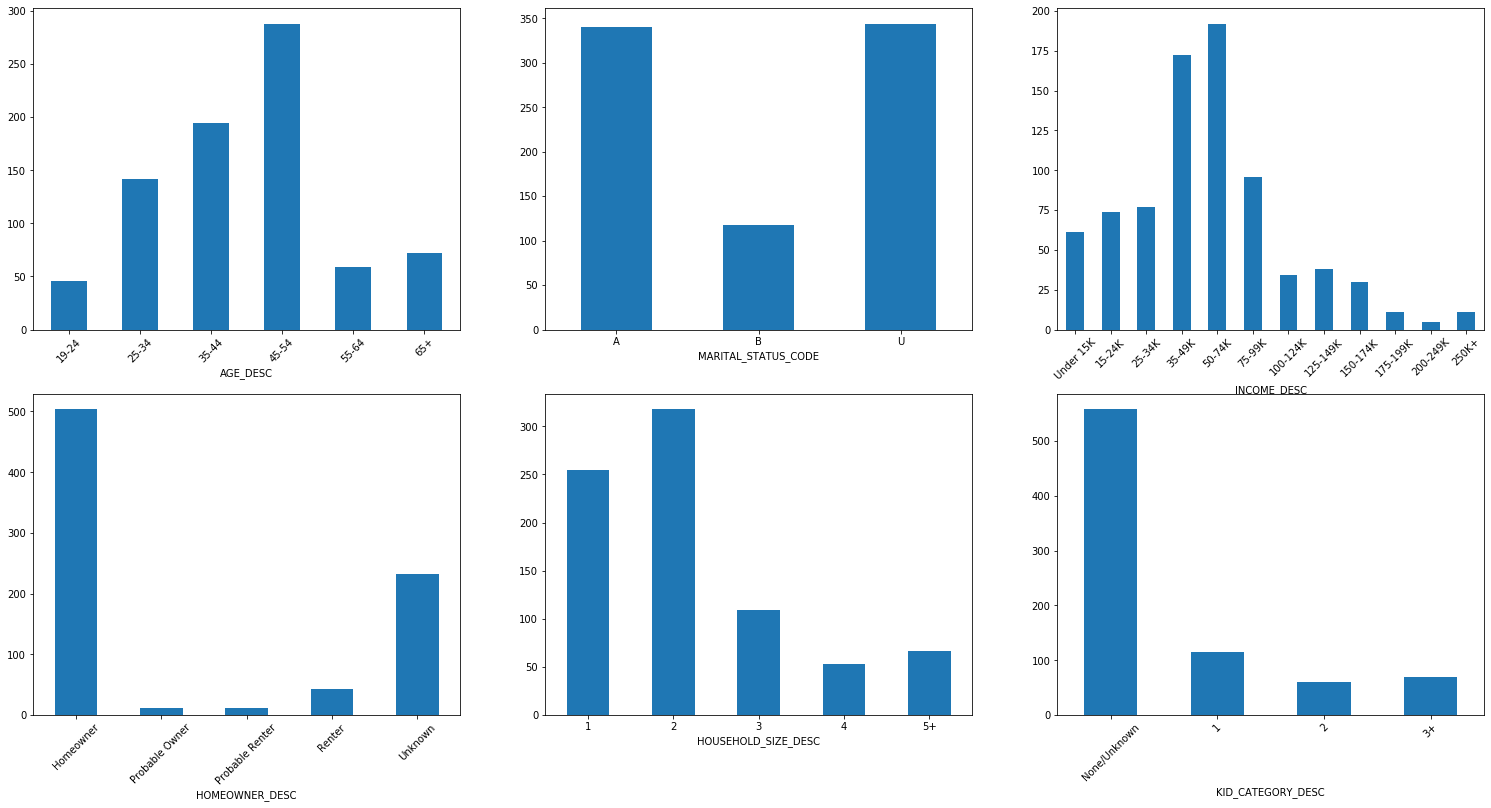

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,13))

for i, n in enumerate(['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC']):
    df_household.groupby(n)['household_key'].count().plot.bar(ax=axes[i // 3,i % 3])
    
    if i in [0, 2, 3, 5]:
        axes[i // 3,i % 3].set_xticklabels(axes[i // 3,i % 3].get_xticklabels(), rotation=45)
    else:
        axes[i // 3,i % 3].set_xticklabels(axes[i // 3,i % 3].get_xticklabels(), rotation=0)    

From the graph above we realise that income ranges above 100K and below 50 are not represented by large numbers. Thus, we decided to merge them to have more concrete result in our further analysis. The categories between 50 and 100K are also merged to keep three categories only. The same observation and merging is made for age categories below 35 and over 55.

In [8]:
# merge some income categories
cat_to_combine_under50K = ["Under 15K", "15-24K", "25-34K", "35-49K"]
cat_to_combine_between50K_100K = ["50-74K", "75-99K"]
cat_to_combine_over100K = ["100-124K", "125-149K", "150-174K", "175-199K", "200-249K", "250K+"]
def combine_cat_income(x):
    if x in cat_to_combine_over100K:
        return "100K+"
    elif x in cat_to_combine_between50K_100K:
        return "50-99K"
    elif x in cat_to_combine_under50K:
        return "Under 50K"
    else:
        print(x)
        return 'ERROR'
    
df_household['INCOME_DESC'] = df_household['INCOME_DESC'].apply(combine_cat_income)

# merge some age categories
cat_to_combine_over55 = ["55-64", "65+"]
cat_to_combine_under35 = ["19-24", "25-34"]
def combine_cat_age(x):
    if x in cat_to_combine_over55:
        return "55+" 
    elif x in cat_to_combine_under35:
        return "19-34"
    else: 
        return x
    
df_household['AGE_DESC'] = df_household['AGE_DESC'].apply(combine_cat_age)

# correct dtypes
df_household['INCOME_DESC'] = pd.Categorical(df_household['INCOME_DESC'].values, categories=['Under 50K', '50-99K', '100K+'], ordered=True)
df_household['AGE_DESC'] = pd.Categorical(df_household['AGE_DESC'].values, categories=['19-34', '35-44', '45-54', '55+'], ordered=True)

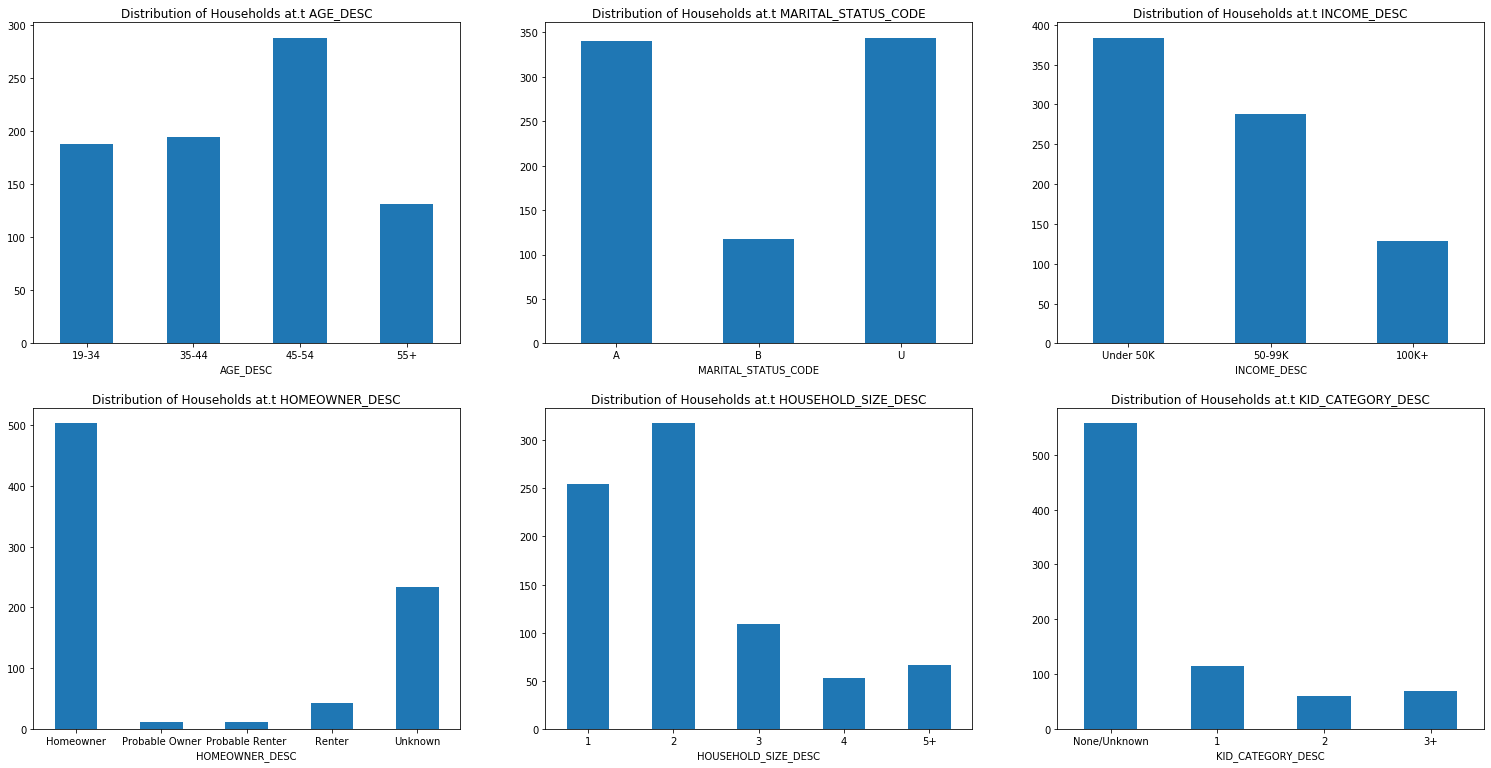

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,13))

for i, n in enumerate(['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC']):
    df_household.groupby(n)['household_key'].count().plot.bar(ax=axes[i // 3,i % 3], title='Distribution of Households at.t ' + n)
    axes[i // 3,i % 3].set_xticklabels(axes[i // 3,i % 3].get_xticklabels(), rotation=0)

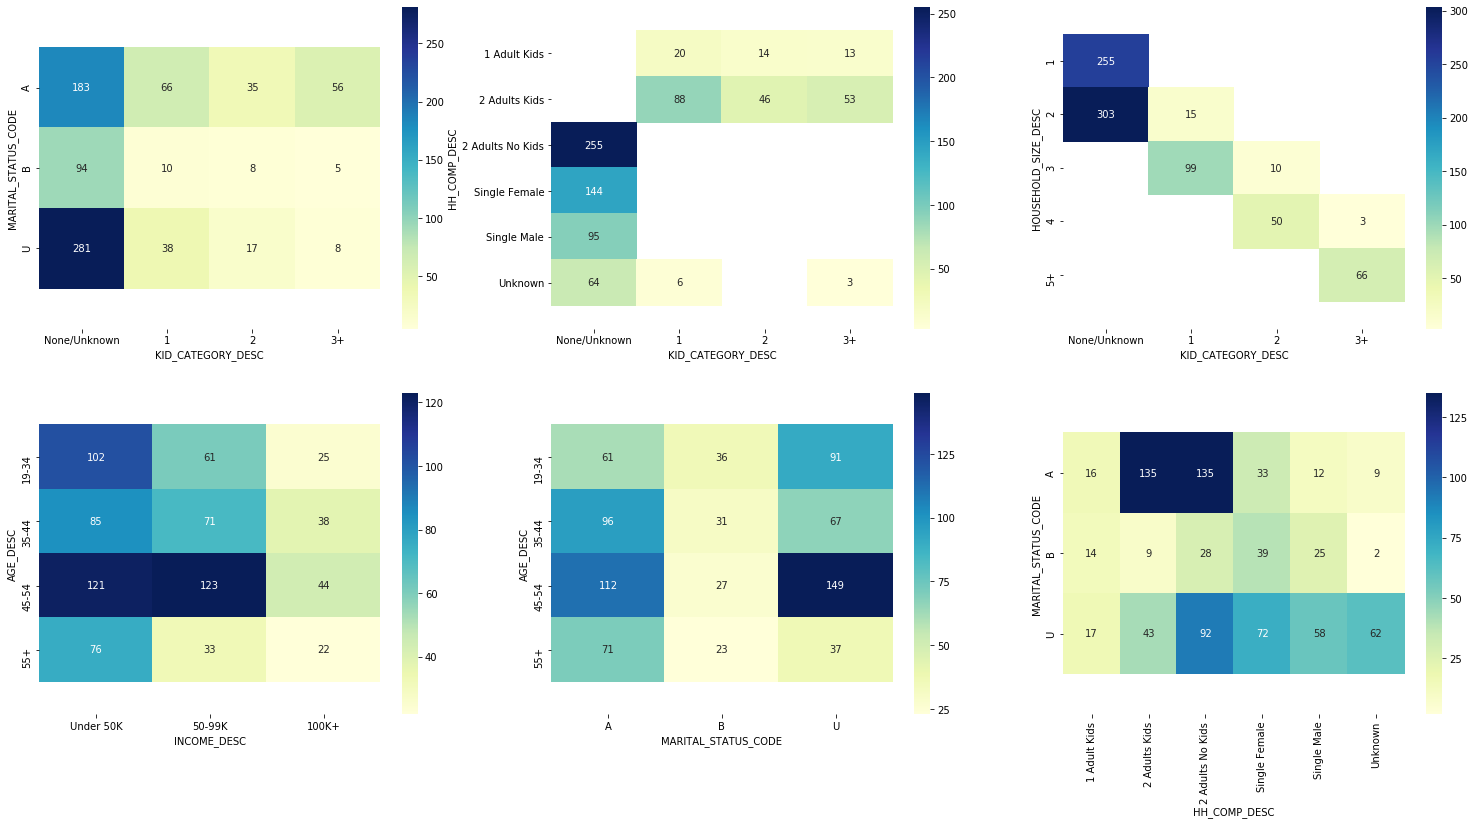

In [10]:
tuples = [ ('MARITAL_STATUS_CODE', 'KID_CATEGORY_DESC'),
 ('HH_COMP_DESC', 'KID_CATEGORY_DESC'),
 ('HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC'),
 ('AGE_DESC', 'INCOME_DESC'),
 ('AGE_DESC', 'MARITAL_STATUS_CODE'),
 ('MARITAL_STATUS_CODE', 'HH_COMP_DESC')]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,13))

for i, t in enumerate(tuples):
    df_dummy = df_household.groupby([t[0], t[1]]).count()\
        .reset_index().pivot(index= t[0], columns= t[1], values='household_key')
    
    sns.heatmap(df_dummy, annot=True, fmt=".0f", annot_kws={"size": 10}, cmap="YlGnBu", ax=axes[i // 3,i % 3])
    
    b, t = axes[i // 3,i % 3].set_ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    axes[i // 3,i % 3].set_ylim(b, t) # update the ylim(bottom, top) values

In general, we have found the distributions expected. Specifically, we observed that there are 64 households with unknown family info. Moreover, there are households with only one male and female so that we can apply some cross-gender analysis in individual level. 

In [11]:
# add new usefull columns

# for gender column
def create_gender_column(row):
    if row['HH_COMP_DESC'] == 'Single Female':
        return 'Female'
    elif row['HH_COMP_DESC'] == 'Single Male':
        return 'Male'
    else:
        return None

# for faimly_info_exist column
def create_family_info_column(row):
    return not (row['HH_COMP_DESC'] == 'Unknown' and row['KID_CATEGORY_DESC'] == 'None/Unknown')

# create columns
df_household['GENDER'] = df_household.apply (lambda row: create_gender_column(row), axis=1)
df_household['FAMILY_INFO_EXIST'] = df_household.apply (lambda row: create_family_info_column(row), axis=1)

df_household.head()

AGE_DESC MARITAL_STATUS_CODE INCOME_DESC HOMEOWNER_DESC      HH_COMP_DESC  \
0      55+                   A   Under 50K      Homeowner  2 Adults No Kids   
1    45-54                   A      50-99K      Homeowner  2 Adults No Kids   
2    19-34                   U   Under 50K        Unknown     2 Adults Kids   
3    19-34                   U      50-99K      Homeowner     2 Adults Kids   
4    45-54                   B      50-99K      Homeowner     Single Female   

  HOUSEHOLD_SIZE_DESC KID_CATEGORY_DESC  household_key  GENDER  \
0                   2      None/Unknown              1    None   
1                   2      None/Unknown              7    None   
2                   3                 1              8    None   
3                   4                 2             13    None   
4                   1      None/Unknown             16  Female   

   FAMILY_INFO_EXIST  
0               True  
1               True  
2               True  
3               True  
4               True

## Products
Exploratory analysis for the products dataset.

In [12]:
df_products = pd.read_csv('dunnhumby/product.csv', sep = ',')
df_products.head()

PRODUCT_ID  MANUFACTURER    DEPARTMENT     BRAND            COMMODITY_DESC  \
0       25671             2       GROCERY  National                  FRZN ICE   
1       26081             2  MISC. TRANS.  National  NO COMMODITY DESCRIPTION   
2       26093            69        PASTRY   Private                     BREAD   
3       26190            69       GROCERY   Private      FRUIT - SHELF STABLE   
4       26355            69       GROCERY   Private             COOKIES/CONES   

            SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
0          ICE - CRUSHED/CUBED                22 LB  
1  NO SUBCOMMODITY DESCRIPTION                       
2         BREAD:ITALIAN/FRENCH                       
3                  APPLE SAUCE                50 OZ  
4            SPECIALTY COOKIES                14 OZ

In [13]:
print('There are {0} rows and {1} columns in the dataset.'.format(len(df_products), len(df_products.columns))) 

There are 92353 rows and 7 columns in the dataset.


In [14]:
print('Number of columns with missing values is {0}.'.format(len(df_products.columns.to_numpy()[df_products.isna().any()])))

Number of columns with missing values is 0.


In [15]:
print('Columns:')
print('--------')
for col in df_products.columns:
    print(col)

Columns:
--------
PRODUCT_ID
MANUFACTURER
DEPARTMENT
BRAND
COMMODITY_DESC
SUB_COMMODITY_DESC
CURR_SIZE_OF_PRODUCT


In [16]:
print('There are {0} unique products distributed in {1} different departments.'.format(len(df_products['PRODUCT_ID'].unique()), len(df_products['DEPARTMENT'].unique())))

There are 92353 unique products distributed in 44 different departments.


After some investigation, the COMMODITY_DESC column is not using a standardized notation despite such a standardization existing (see [here](https://unstats.un.org/unsd/tradekb/Knowledgebase/50018/Harmonized-Commodity-Description-and-Coding-Systems-HS)).

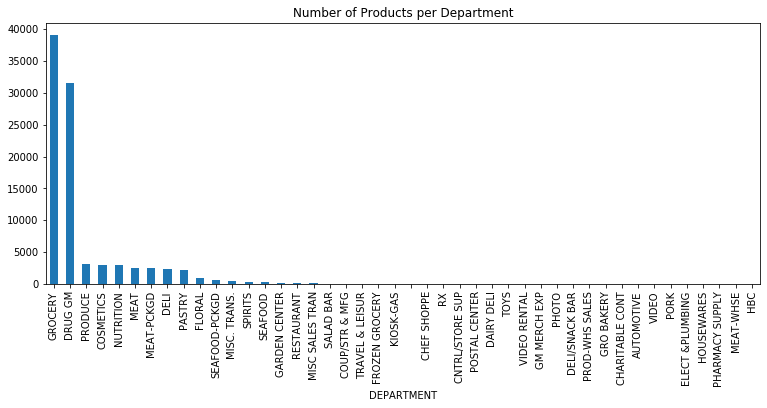

In [17]:
df_products.groupby("DEPARTMENT").count()["PRODUCT_ID"].sort_values(ascending=False).plot.bar(figsize=default_figsize)
plt.title('Number of Products per Department');

In [18]:
percent = int(len(df_products[df_products.DEPARTMENT == 'GROCERY']) * 100 / len(df_products))
print(f'The GROCERY department contains nearly {percent}% of the products in the food sector.')

The GROCERY department contains nearly 42% of the products in the food sector.


### Food Products

For this project, the main interest is food products. Therefore, a dataframe with only food-related departments is created.

In [19]:
df_food_products = pd.read_csv('data/food_products.csv')

In [20]:
print('There are {0} unique food products distributed in {1} different departments.'.format(len(df_food_products['PRODUCT_ID'].unique()), len(df_food_products['DEPARTMENT'].unique())))

There are 51341 unique food products distributed in 18 different departments.


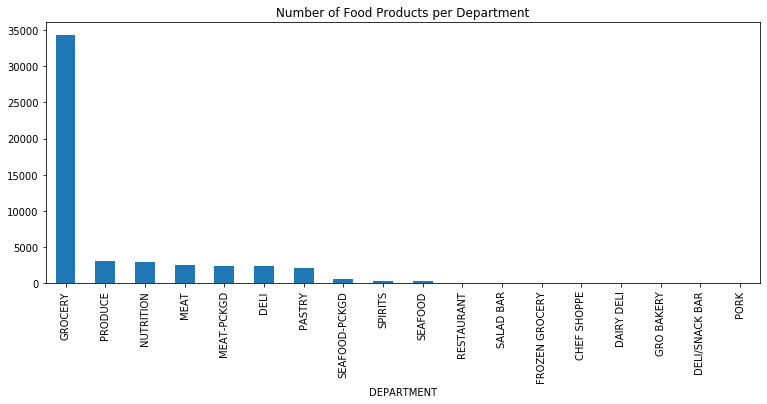

In [21]:
df_food_products.groupby("DEPARTMENT").count()["PRODUCT_ID"].sort_values(ascending=False).plot.bar(figsize=default_figsize)
plt.title('Number of Food Products per Department');

In [22]:
percent = int(len(df_food_products[df_food_products.DEPARTMENT == 'GROCERY']) * 100 / len(df_food_products))
print(f'The GROCERY department contains nearly {percent}% of the products in the food sector.')

The GROCERY department contains nearly 66% of the products in the food sector.


### Products containing meat
Our analysis being meat centered, it is of major interest to have a dataset with only products containing meat.

In [23]:
df_meat_products = pd.read_csv('data/meat_products.csv')

In [24]:
print('There are {0} unique meat products distributed in {1} different departments.'.format(len(df_meat_products['PRODUCT_ID'].unique()), len(df_meat_products['DEPARTMENT'].unique())))

There are 8785 unique meat products distributed in 10 different departments.


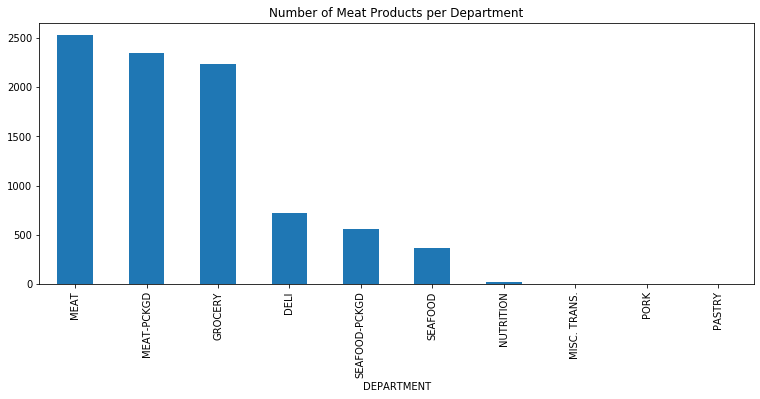

In [25]:
df_meat_products.groupby("DEPARTMENT").count()["PRODUCT_ID"].sort_values(ascending=False).plot.bar(figsize=default_figsize)
plt.title('Number of Meat Products per Department');

Most of the meat products are in the 'MEAT', 'MEAT_PCKGD' and 'GROCERY' departments. 
Another dataset is created for only pure meat products. This dataset contains an extra column with the meat's origin animal ('BOVINE', 'OVINE', 'PORK', 'POULTRY', 'SEAFOOD', 'UNKNOWN").

In [26]:
df_pure_meat = pd.read_csv("data/pure_meat_products.csv")
df_red_meat = df_pure_meat[df_pure_meat.MEAT_TYPE.isin(['BOVINE', 'OVINE','PORK'])]
df_white_meat = df_pure_meat[df_pure_meat.MEAT_TYPE.isin(['POULTRY'])]
df_sea_food = df_pure_meat[df_pure_meat.MEAT_TYPE.isin(['SEAFOOD'])]

### Vegetables products
A final dataset is created with only vegetables products.

In [27]:
df_veggies_products = pd.read_csv('data/vegetables_products.csv')

In [28]:
print('There are {0} unique vegetable products distributed in {1} different departments.'.format(len(df_veggies_products['PRODUCT_ID'].unique()), len(df_veggies_products['DEPARTMENT'].unique())))

There are 3209 unique vegetable products distributed in 7 different departments.


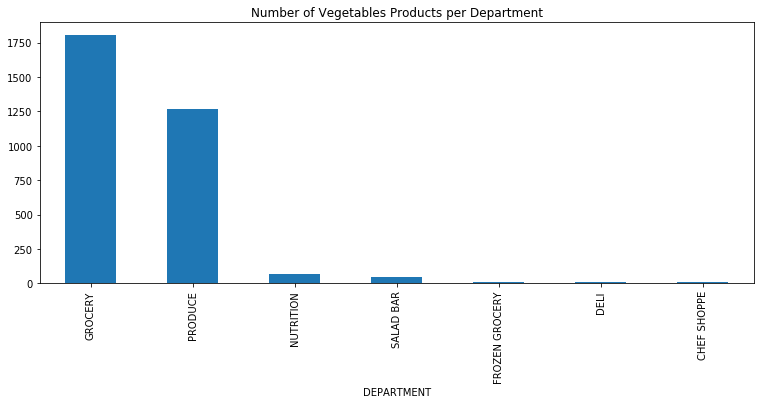

In [29]:
df_veggies_products.groupby("DEPARTMENT").count()["PRODUCT_ID"].sort_values(ascending=False).plot.bar(figsize=default_figsize)
plt.title('Number of Vegetables Products per Department');

We can now look at the number of products we have for each category :

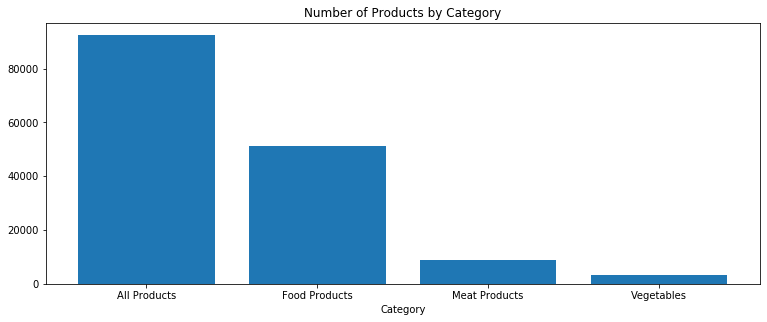

In [30]:
x = np.arange(4)
y = [len(df_products), len(df_food_products), len(df_meat_products), len(df_veggies_products)]
plt.figure(figsize = default_figsize)
plt.bar( x, y)
plt.xticks(x, ( 'All Products', 'Food Products', 'Meat Products', 'Vegetables'))
plt.xlabel("Category")
plt.title("Number of Products by Category")
plt.show()

## Transactions

This csv file contains more than 2 million transactions. Each transactiction is identified by a household, a product id and a basket id.

In [31]:
# Load the dataset
df_transactions = pd.read_csv('dunnhumby/transaction_data.csv', sep = ',')
df_transactions.head()

household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
0           2375  26984851472    1     1004906         1         1.39   
1           2375  26984851472    1     1033142         1         0.82   
2           2375  26984851472    1     1036325         1         0.99   
3           2375  26984851472    1     1082185         1         1.21   
4           2375  26984851472    1     8160430         1         1.50   

   STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  COUPON_MATCH_DISC  
0       364        -0.60        1631        1          0.0                0.0  
1       364         0.00        1631        1          0.0                0.0  
2       364        -0.30        1631        1          0.0                0.0  
3       364         0.00        1631        1          0.0                0.0  
4       364        -0.39        1631        1          0.0                0.0

In [32]:
print('There are {0} rows and {1} columns in the dataset.'.format(len(df_transactions), len(df_transactions.columns))) 

There are 2595732 rows and 12 columns in the dataset.


In [33]:
print('Number of columns with missing values is {0}.'.format(len(df_transactions.columns.to_numpy()[df_transactions.isna().any()])))

Number of columns with missing values is 0.


In [34]:
print('Columns:')
print('--------')
for col in df_transactions.columns:
    print(col)

Columns:
--------
household_key
BASKET_ID
DAY
PRODUCT_ID
QUANTITY
SALES_VALUE
STORE_ID
RETAIL_DISC
TRANS_TIME
WEEK_NO
COUPON_DISC
COUPON_MATCH_DISC


The column named SALES_VALUE does not represent what a client paid for a product. It represents the raw value of a product that does not take into account the potential discounts. To be able to analyse the expenses of the customers we want to create a column PAID_PRICE that contains the actual amount that the customer paid. 

The paid price is calculated as follows :

PAID_PRICE = (SALES_VALUE - ( |RETAIL_DISC| + |COUPON_MATCH_DISC|)) 

In [35]:
df_transactions["PAID_PRICE"] = (df_transactions.SALES_VALUE - (df_transactions.RETAIL_DISC.abs() + df_transactions.COUPON_MATCH_DISC.abs()))
df_transactions["PAID_PRICE"] = df_transactions["PAID_PRICE"].clip(lower=0)
df_transactions.head()

household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
0           2375  26984851472    1     1004906         1         1.39   
1           2375  26984851472    1     1033142         1         0.82   
2           2375  26984851472    1     1036325         1         0.99   
3           2375  26984851472    1     1082185         1         1.21   
4           2375  26984851472    1     8160430         1         1.50   

   STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  COUPON_MATCH_DISC  \
0       364        -0.60        1631        1          0.0                0.0   
1       364         0.00        1631        1          0.0                0.0   
2       364        -0.30        1631        1          0.0                0.0   
3       364         0.00        1631        1          0.0                0.0   
4       364        -0.39        1631        1          0.0                0.0   

   PAID_PRICE  
0        0.79  
1        0.82  
2        0.69  
3        1.21  
4        1.11

We found [a github project](https://github.com/Lanbig/CSC465-visualization-project) in which the author makes a calendar visualization of the Dunnhumby dataset. According to him, the day 1 corresponds to 24th of march 2010.

We create a new column containing the date in the dataframe :

In [36]:
start_date = datetime(2010, 3, 24)
def convert_day_to_date(day):
    date = start_date + timedelta(days=day-1)
    return date

df_transactions["DATE"] = df_transactions.DAY.apply(convert_day_to_date)

In [37]:
trans_per_day = df_transactions.groupby("DATE")["household_key"].count().reset_index(name="count").reset_index()
fig = px.line(trans_per_day, x='DATE', y='count')
fig.update_layout(title="Transactions")
fig.show()

We observe a peak in the number of transactions on 24th of December and a low on the 26th which is a holiday. This makes us confident that  the start date that we found is correct.

If we look only at the transactions for Turkey meat (see below), we observe two peaks around the 20th of November which corresponds to Thanksgiving. As this is a US specific holiday. We think that the dataset might have been collected in the US.

In [38]:
# Get turkey transactions
df_turkey_meat = df_meat_products[df_meat_products.COMMODITY_DESC.str.contains("TURKEY")]
df_turkey_meat_transactions = pd.merge(df_turkey_meat, df_transactions, on="PRODUCT_ID", how="inner")
trans_per_day_turkey = df_turkey_meat_transactions.groupby("DATE")["household_key"].count().reset_index(name="count").reset_index()
# Plot
fig = px.line(trans_per_day_turkey, x='DATE', y='count')
fig.update_layout(title="Transactions for turkey meat")
fig.show()

#### Time column

In [39]:
print(f"Minimum value for the TRANS_TIME: {df_transactions.TRANS_TIME.min()}")
print(f"Maximum value for the TRANS_TIME: {df_transactions.TRANS_TIME.max()}")

Minimum value for the TRANS_TIME: 0
Maximum value for the TRANS_TIME: 2359


This column actually contains the time a which the transaction took place. The time is represented by an integer between 0 and 2359 that respectively corresponds to midnight and 23:59.  

We only keep the transactions related to food prodcuts for the rest of the analysis.

In [40]:
food_products_IDs = df_food_products.PRODUCT_ID.values
df_food_transactions = df_transactions[df_transactions.PRODUCT_ID.isin(food_products_IDs)]

df_meat_transactions = pd.merge(df_meat_products, df_food_transactions, on="PRODUCT_ID", how="inner")
df_veggies_transactions = pd.merge(df_veggies_products, df_food_transactions, on="PRODUCT_ID", how="inner")

df_pure_meat_transactions = pd.merge(df_pure_meat, df_food_transactions, on="PRODUCT_ID", how="inner")
df_red_meat_transactions = pd.merge(df_red_meat, df_food_transactions, on="PRODUCT_ID", how="inner")
df_white_meat_transactions = pd.merge(df_white_meat, df_food_transactions, on="PRODUCT_ID", how="inner")
df_sea_food_transactions = pd.merge(df_sea_food, df_food_transactions, on="PRODUCT_ID", how="inner")

In [41]:
print(f"The food transactions dataframe contains {len(df_food_transactions)} transactions.")

The food transactions dataframe contains 2130905 transactions.


In [42]:
print(f"The food transactions dataframe contains {len(df_food_transactions.BASKET_ID.unique())} baskets.")

The food transactions dataframe contains 225792 baskets.


### Basket Prices

To get an idea of how the people consume in the dataset, we are interested in knowing what is the distribution of the basket prices.

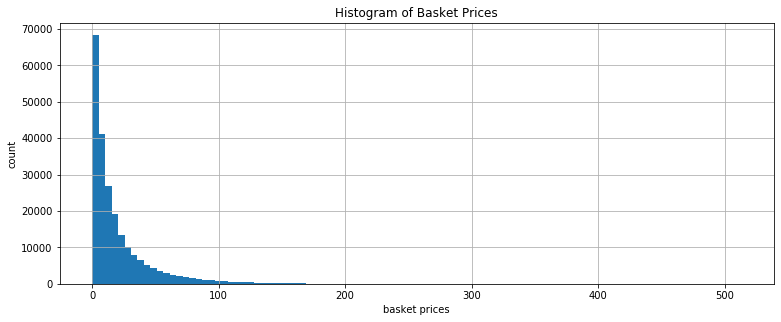

In [43]:
df_food_transactions.groupby("BASKET_ID").PAID_PRICE.sum().hist(bins=100,figsize=default_figsize)
plt.xlabel('basket prices')
plt.ylabel('count')
plt.title('Histogram of Basket Prices');

In [44]:
basket_prices = df_transactions.groupby("BASKET_ID").PAID_PRICE.sum()
print(f"The median basket price is {round(basket_prices.median(), 2)} $.")

The median basket price is 14.29 $.


It seems that the basket price follows a exponential distribution. We can plot it on a semi-log scale :

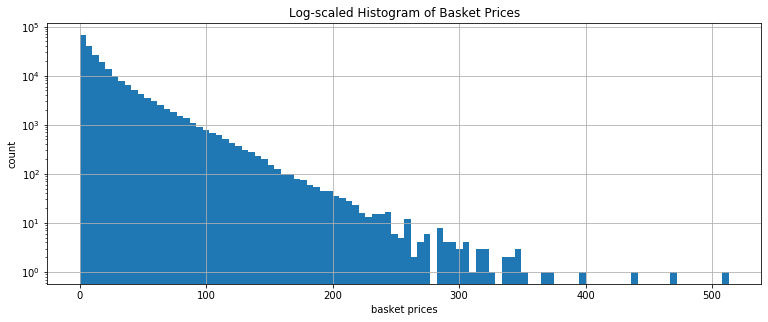

In [45]:
df_food_transactions.groupby("BASKET_ID").PAID_PRICE.sum().hist(bins=100, figsize=default_figsize)
plt.yscale("log")
plt.xlabel('basket prices')
plt.ylabel('count')
plt.title('Log-scaled Histogram of Basket Prices');

We see that there are some baskets that cost 0 dollars. Let's have a look at one of those baskets :

In [46]:
free_products = len(df_food_transactions[df_food_transactions.PAID_PRICE == 0])
percent_free_products = round(free_products * 100 / len(df_food_transactions), 2)
print(f"There are {free_products} products that were bought for free which is {percent_free_products}% of food related transcations.")

There are 73069 products that were bought for free which is 3.43% of food related transcations.


In [47]:
df_food_transactions[df_food_transactions.PAID_PRICE == 0].sample(5)

household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
78891              691  27817163886   70      913785         1         0.88   
1757624            508  34811891206  505      910032         2         1.98   
2131508           2058  40702985850  600     1006978         1         0.79   
911579            1520  31356141699  295     1117514         1         0.99   
1903441           1822  36029467279  542      909899         0         0.00   

         STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  \
78891         439        -1.11        2251       11          0.0   
1757624       372        -4.60        1210       73          0.0   
2131508       367        -0.90        1713       86         -0.5   
911579        335        -1.00        1701       43          0.0   
1903441       368         0.00        2055       78          0.0   

         COUPON_MATCH_DISC  PAID_PRICE       DATE  
78891                  0.0         0.0 2010-06-01  
1757624                0.0         0.0 2011-08-10  
2131508               -0.5         0.0 2011-11-13  
911579                 0.0         0.0 2011-01-12  
1903441                0.0         0.0 2011-09-16

For these products, we observe that the discount is bigger than the sales value. This explains why some transactions do not cost anything to the buyer.

### Basket Sizes

We are also interested in the quantity of products that the consumers buy.

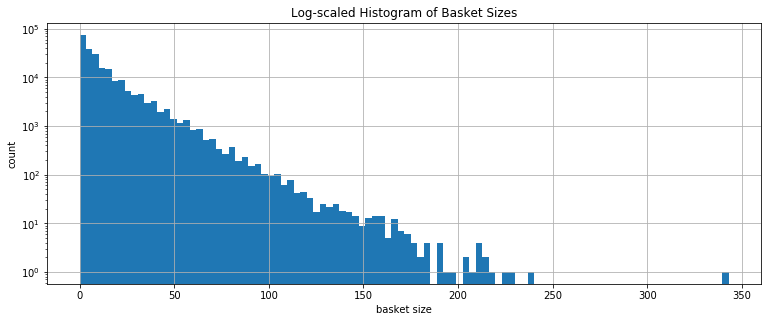

In [48]:
df_food_transactions.groupby("BASKET_ID")["QUANTITY"].sum().hist(bins=100, figsize=default_figsize)
plt.yscale("log")
plt.xlabel('basket size')
plt.ylabel('count')
plt.title('Log-scaled Histogram of Basket Sizes');

In [49]:
basket_size = df_food_transactions.groupby("BASKET_ID")["QUANTITY"].sum()
print(f"The median basket size is {int(basket_size.median())}.")

The median basket size is 6.


It seems that people have relatively small baskets in general. A possible exaplanation is that they do not make their "heavy" groceries in the stores in which the data were collected.

### Department-level Analysis

To understand what people buy, we look at the distribution of the food related transactions across the departments. 

In [50]:
transac_prod = pd.merge(df_food_transactions, df_food_products, on="PRODUCT_ID", how="inner")[["PRODUCT_ID", "PAID_PRICE", "DEPARTMENT"]]

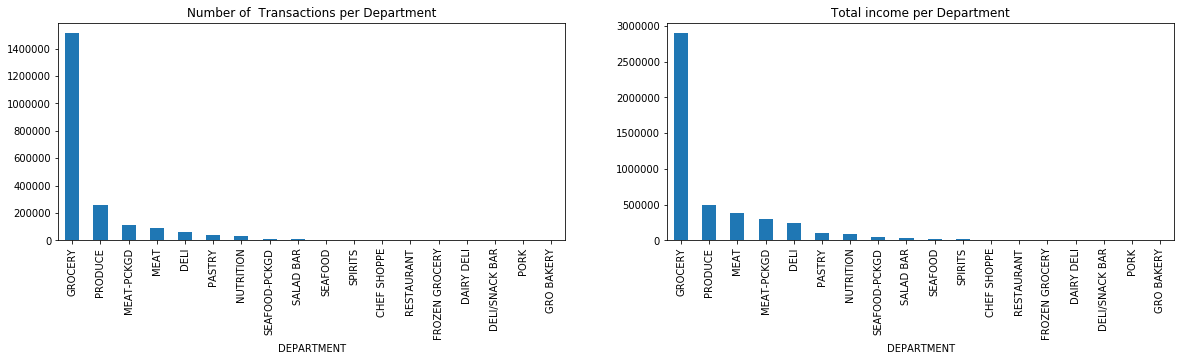

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
transac_prod.groupby("DEPARTMENT")["PAID_PRICE"].count().sort_values(ascending=False).plot.bar(title='Number of  Transactions per Department', ax = axes[0])
transac_prod.groupby("DEPARTMENT")["PAID_PRICE"].sum().sort_values(ascending=False).plot.bar(title='Total income per Department', ax = axes[1]);

We observe that most of the transactions concern products of the GROCERY department which is not surprising as this is the biggest food-related department and it contains a bit of everything.

### Most sold and most profitable products

In continuity, we would also like to find out what are the most sold and most profitable products.

In [52]:
transac_prod = pd.merge(df_food_transactions, df_food_products, on="PRODUCT_ID", how="inner")

In [53]:
ranking_sells = transac_prod.groupby(['PRODUCT_ID'], as_index=False)\
            .agg({'COMMODITY_DESC': 'first', 'SUB_COMMODITY_DESC': 'first', 'PAID_PRICE': 'count'})\
            .rename(columns={"PAID_PRICE": "NUM_SOLD"})\
            .sort_values(by="NUM_SOLD", ascending=False)\
            .head(10)
ranking_sells["RANK"] = ranking_sells["NUM_SOLD"].rank(ascending=False)
ranking_sells = ranking_sells.set_index("RANK")
print("Ranking of the Most sold products: ")
ranking_sells.head(10)

Ranking of the Most sold products: 


PRODUCT_ID          COMMODITY_DESC      SUB_COMMODITY_DESC  NUM_SOLD
RANK                                                                      
1.0      1082185          TROPICAL FRUIT                 BANANAS     29778
2.0      1029743     FLUID MILK PRODUCTS   FLUID MILK WHITE ONLY     14430
3.0       995242     FLUID MILK PRODUCTS   FLUID MILK WHITE ONLY     12542
4.0      1106523     FLUID MILK PRODUCTS   FLUID MILK WHITE ONLY      9826
5.0       981760                    EGGS          EGGS - X-LARGE      9126
6.0      1133018     FLUID MILK PRODUCTS   FLUID MILK WHITE ONLY      7315
7.0       883404  BAKED BREAD/BUNS/ROLLS  MAINSTREAM WHITE BREAD      6904
8.0       951590  BAKED BREAD/BUNS/ROLLS  MAINSTREAM WHITE BREAD      6138
9.0       826249  BAKED BREAD/BUNS/ROLLS          HAMBURGER BUNS      5505
10.0      840361                    EGGS            EGGS - LARGE      5338

In [54]:
ranking_profit = transac_prod.groupby(['PRODUCT_ID'], as_index=False)\
            .agg({'COMMODITY_DESC': 'first', 'SUB_COMMODITY_DESC': 'first', 'PAID_PRICE': 'sum'})\
            .sort_values(by="PAID_PRICE", ascending=False)\
            .head(10)
ranking_profit["RANK"] = ranking_profit["PAID_PRICE"].rank(ascending=False)
ranking_profit = ranking_profit.set_index("RANK")
print("Ranking of the Most profitable products: ")
ranking_profit.head()

Ranking of the Most profitable products: 


PRODUCT_ID       COMMODITY_DESC     SUB_COMMODITY_DESC  PAID_PRICE
RANK                                                                    
1.0      1029743  FLUID MILK PRODUCTS  FLUID MILK WHITE ONLY    38451.09
2.0      1082185       TROPICAL FRUIT                BANANAS    27168.62
3.0      1106523  FLUID MILK PRODUCTS  FLUID MILK WHITE ONLY    26147.93
4.0       844179                 BEEF                 PRIMAL    14574.54
5.0      1044078                 BEEF                   LEAN    12970.96

We did not really expect Bananas to be at the the top of the ranking. As for the other products, milk, beef, eggs and bread, in the top 10 this was fairly predictable.

### Analysis of Weekly spending per Household

The analysis of the spending per household will be very important to answer our research questions.

In this section, we will focus on spendings for meat, vegetables and food in general. The goal is to get an idea of what are the average spending for each of them and to discover the ratio of the spendings allocated to meat and vegetables.  

In [55]:
def get_stats_meat_veggies(df_meat, df_veggies):
    """
    Returns a dataframe containg the :
      - % of transactions
      - % of spendings
    for meat and vegetables related products
    """
    indexes = ["MEAT", "VEGGIES"]
    total_spent = df_food_transactions.PAID_PRICE.sum()

    _dict = {
        "TRANSACTIONS_%": [],
        "SPENDING_%": [],
    }
    for df in df_meat, df_veggies:
        _dict["TRANSACTIONS_%"].append(int(len(df) * 100/len(df_food_transactions)))
        
        total_spent_for_cat = df.PAID_PRICE.sum()
        _dict["SPENDING_%"].append(int(((total_spent_for_cat / total_spent) * 100)))
        
    return pd.DataFrame(_dict, index=indexes)  

When looking at the average spending for a household we only consider weeks in which they have made purchases.

In [56]:
# find active weeks  and total spendings per household
weeks_activity_by_household = df_food_transactions.groupby("household_key").agg({"WEEK_NO": set, "PAID_PRICE": sum})
# create new columns
weeks_activity_by_household["number_of_active_weeks"] = weeks_activity_by_household["WEEK_NO"].apply(lambda x: len(x))
weeks_activity_by_household["avg_spending_per_week"] = weeks_activity_by_household["PAID_PRICE"] / weeks_activity_by_household["number_of_active_weeks"]
# drop week_no and sort
weeks_activity_by_household = weeks_activity_by_household.drop(columns="WEEK_NO")
weeks_activity_by_household = weeks_activity_by_household.sort_values(by="number_of_active_weeks", ascending=False)

We construct dataframes containing only meat related transactions as well as vegetables related transactions.

In [57]:
df_meat_transactions = pd.merge(df_meat_products, df_food_transactions, on="PRODUCT_ID", how="inner")
df_veggies_transactions = pd.merge(df_veggies_products, df_food_transactions, on="PRODUCT_ID", how="inner")

In [58]:
get_stats_meat_veggies(df_meat_transactions, df_veggies_transactions)

TRANSACTIONS_%  SPENDING_%
MEAT                 16          23
VEGGIES               9           7

We observe that 16% of the food related transactions are for meat products and this represents 23% of the spendings. As for the vegetables those represent respectively 9% and 7% of the transactions and the spendings. 

We will now construct a new dataframe containing for each household :
- The total amount paid for meat, vegetables and food in general
- The average spending per active week for meat, vegetables and food in general
- The ratio spend for meat and vegetables (e.g. ratio_for_meat = avg.  weekly spending for meat / avg. weekly spending for food)

In [59]:
# find active weeks  and total spendings per household
weeks_activity_by_household = df_food_transactions.groupby("household_key").agg({"WEEK_NO": set, "PAID_PRICE": sum})
# create new columns
weeks_activity_by_household["number_of_active_weeks"] = weeks_activity_by_household["WEEK_NO"].apply(lambda x: len(x))
weeks_activity_by_household["avg_spending_per_week"] = weeks_activity_by_household["PAID_PRICE"] / weeks_activity_by_household["number_of_active_weeks"]
# drop week_no and sort
weeks_activity_by_household = weeks_activity_by_household.drop(columns="WEEK_NO")
weeks_activity_by_household = weeks_activity_by_household.sort_values(by="number_of_active_weeks", ascending=False).rename(columns={"PAID_PRICE": "PAID_FOOD"})

# find active weeks  and total spendings per household
weeks_activity_by_household = df_food_transactions.groupby("household_key").agg({"WEEK_NO": set, "PAID_PRICE": sum})
# create new columns
weeks_activity_by_household["number_of_active_weeks"] = weeks_activity_by_household["WEEK_NO"].apply(lambda x: len(x))
weeks_activity_by_household["avg_spending_per_week"] = weeks_activity_by_household["PAID_PRICE"] / weeks_activity_by_household["number_of_active_weeks"]
# drop week_no and sort
weeks_activity_by_household = weeks_activity_by_household.drop(columns="WEEK_NO")
weeks_activity_by_household = weeks_activity_by_household.sort_values(by="number_of_active_weeks", ascending=False).rename(columns={"PAID_PRICE": "PAID_FOOD"})

# add more info 
dfs = [df_meat_transactions, df_veggies_transactions, df_pure_meat_transactions, df_red_meat_transactions, df_white_meat_transactions, df_sea_food_transactions]
df_names = ['MEAT', 'VEGGIE', 'PURE_MEAT', 'RED_MEAT', 'WHITE_MEAT', 'SEA_FOOD']

spent_by_household = weeks_activity_by_household.rename(columns={"PAID_PRICE_x": "paid_FOOD", "PAID_PRICE_y": "paid"})
for name, df in zip(df_names, dfs):
    spending = df.groupby("household_key").agg({"PAID_PRICE": sum}).reset_index().rename(columns={"PAID_PRICE": "PAID_" + name})
    spent_by_household = pd.merge(spending, spent_by_household, on="household_key")
    
    spent_by_household['avg_spending_per_week_' + name] = spent_by_household['PAID_' + name] / spent_by_household['number_of_active_weeks']
    spent_by_household['avg_spending_ratio_' + name] = spent_by_household['avg_spending_per_week_' + name] / spent_by_household['avg_spending_per_week']
    
spent_by_household.head()

household_key  PAID_SEA_FOOD  PAID_WHITE_MEAT  PAID_RED_MEAT  \
0              1           8.64           161.68          57.68   
1              2          38.20            52.44          85.50   
2              3           9.47            63.97         208.94   
3              4          12.47            41.88          72.98   
4              6         123.69           384.85         592.27   

   PAID_PURE_MEAT  PAID_VEGGIE  PAID_MEAT  PAID_FOOD  number_of_active_weeks  \
0          261.16       292.81     380.95    2812.21                      67   
1          200.66        58.14     225.75    1082.74                      31   
2          393.85        41.01     567.90    1711.78                      36   
3          156.83         9.70     177.87     679.48                      25   
4         1104.95       371.72    1141.56    3794.65                      84   

   avg_spending_per_week  ...  avg_spending_per_week_VEGGIE  \
0              41.973284  ...                      4.370299   
1              34.927097  ...                      1.875484   
2              47.549444  ...                      1.139167   
3              27.179200  ...                      0.388000   
4              45.174405  ...                      4.425238   

   avg_spending_ratio_VEGGIE  avg_spending_per_week_PURE_MEAT  \
0                   0.104121                         3.897910   
1                   0.053697                         6.472903   
2                   0.023958                        10.940278   
3                   0.014276                         6.273200   
4                   0.097959                        13.154167   

   avg_spending_ratio_PURE_MEAT  avg_spending_per_week_RED_MEAT  \
0                      0.092866                        0.860896   
1                      0.185326                        2.758065   
2                      0.230082                        5.803889   
3                      0.230809                        2.919200   
4                      0.291186                        7.050833   

   avg_spending_ratio_RED_MEAT  avg_spending_per_week_WHITE_MEAT  \
0                     0.020511                          2.413134   
1                     0.078966                          1.691613   
2                     0.122060                          1.776944   
3                     0.107406                          1.675200   
4                     0.156080                          4.581548   

   avg_spending_ratio_WHITE_MEAT  avg_spending_per_week_SEA_FOOD  \
0                       0.057492                        0.128955   
1                       0.048433                        1.232258   
2                       0.037370                        0.263056   
3                       0.061635                        0.498800   
4                       0.101419                        1.472500   

   avg_spending_ratio_SEA_FOOD  
0                     0.003072  
1                     0.035281  
2                     0.005532  
3                     0.018352  
4                     0.032596  

[5 rows x 22 columns]

We can look at the distribution of the average spending per week :

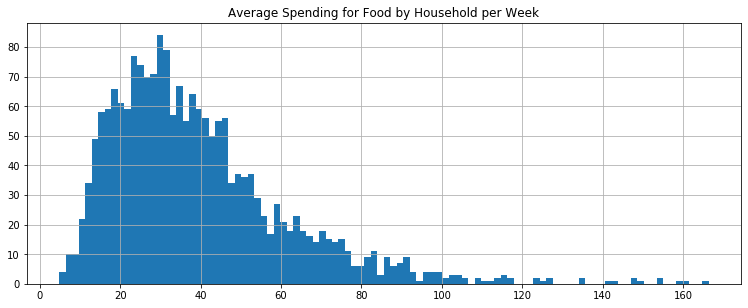

In [60]:
spent_by_household.avg_spending_per_week.hist(bins=100, figsize=default_figsize)
plt.title("Average Spending for Food by Household per Week")
plt.show();

We can also compare the spendings for meat with the spending for vegetables :

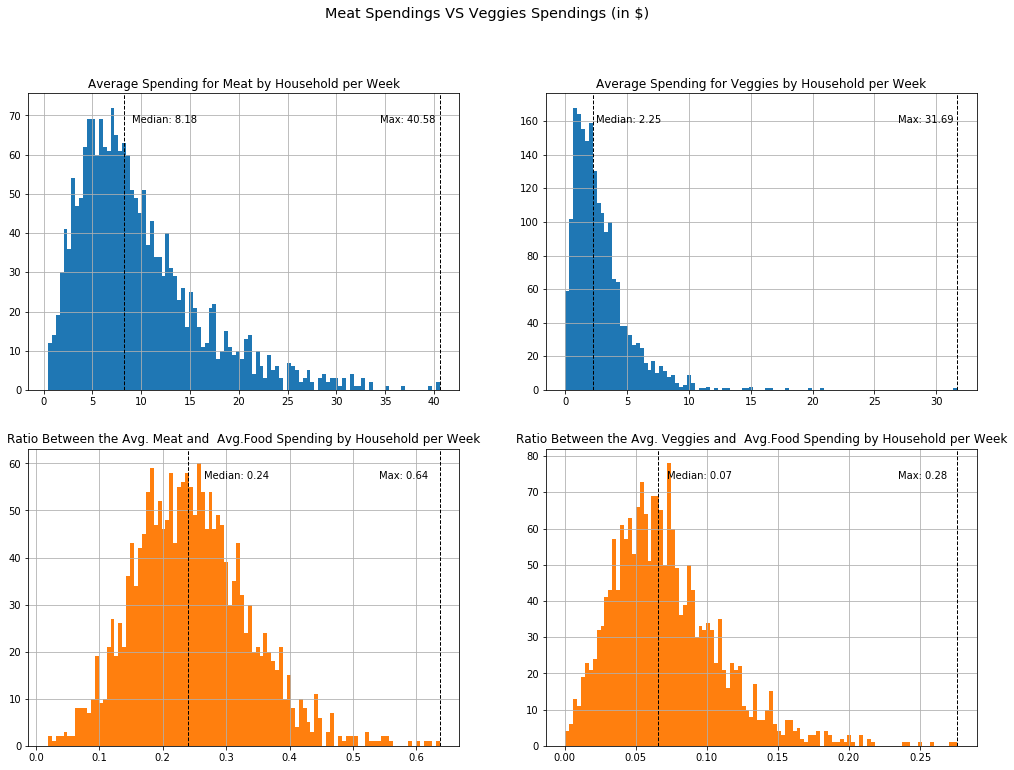

In [61]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,12))
to_plot = {
    "Average Spending for Meat by Household per Week": spent_by_household.avg_spending_per_week_MEAT,
    "Average Spending for Veggies by Household per Week": spent_by_household.avg_spending_per_week_VEGGIE,
    "Ratio Between the Avg. Meat and  Avg.Food Spending by Household per Week": spent_by_household.avg_spending_ratio_MEAT,
    "Ratio Between the Avg. Veggies and  Avg.Food Spending by Household per Week": spent_by_household.avg_spending_ratio_VEGGIE
}

for i, (title, data) in enumerate(to_plot.items()):
    color = "tab:orange" if i > 1 else "tab:blue" 
    ax =  axes[i // 2][i % 2]
    median = data.median()
    _max = data.max()
    
    data.hist(bins=100, ax=ax, color=color)
    min_ylim, max_ylim = ax.get_ylim()
    ax.set_title(title)
    ax.axvline(median, color='k', linestyle='dashed', linewidth=1)
    ax.axvline(_max, color='k', linestyle='dashed', linewidth=1)
    ax.text(median*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(median))
    ax.text(_max*0.85, max_ylim*0.9, 'Max: {:.2f}'.format(_max))
    
st = fig.suptitle("Meat Spendings VS Veggies Spendings (in $)", fontsize="x-large")
plt.show();

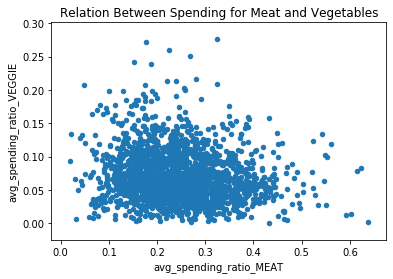

In [62]:
spent_by_household.plot.scatter(x="avg_spending_ratio_MEAT", y="avg_spending_ratio_VEGGIE")
plt.title('Relation Between Spending for Meat and Vegetables');

There seems to be no linear correlation between the spending for meat and vegetables.

### Extreme meat consumers vs extreme veggies consumer

We are also interested in looking at the consumption of the big meat and vegetables spenders. What are the other types of products that they buy ?

To do this analysis, we consider households as big meat/vegeatables if  they are in the 4th quartile of meat/vegetables spendings.

In [63]:
def get_transactions(spending_type, quantile):
    # Get the transactions of the biggest meat consumers
    quantile = spending_type.quantile(quantile)
    households = spent_by_household[spending_type > quantile].household_key.values
    transactions = df_food_transactions[df_food_transactions.household_key.isin(households)]
    transactions_with_prod_info = pd.merge(transactions, df_products, how="inner")    
    return list(households), transactions_with_prod_info

biggest_meat_buyers, biggest_meat_consumers_transactions = get_transactions(spent_by_household.avg_spending_ratio_MEAT, quantile=0.75)
biggest_veggies_buyers, biggest_veggie_consumers_transactions = get_transactions(spent_by_household.avg_spending_ratio_VEGGIE, quantile=0.75)

print(f"The 4th quartile corresponds to {len(biggest_veggies_buyers)} households")

households_in_both = list(set(biggest_meat_buyers).intersection(biggest_veggies_buyers))
print(f"Out of those {len(biggest_veggies_buyers)} household, {len(households_in_both)} of them (={round((len(households_in_both) / len(biggest_meat_buyers)) * 100, 2)}%) are both big meat buyers and big veggies buyers.")

The 4th quartile corresponds to 488 households
Out of those 488 household, 91 of them (=18.65%) are both big meat buyers and big veggies buyers.


We only consider households that appear in one of the two groups. Doing that we have two distinct groups of people.

In [64]:
# Remove houselds that are in the two groups
biggest_meat_consumers_transactions = biggest_meat_consumers_transactions[~biggest_meat_consumers_transactions.household_key.isin(households_in_both)]
biggest_veggie_consumers_transactions = biggest_veggie_consumers_transactions[~biggest_veggie_consumers_transactions.household_key.isin(households_in_both)]

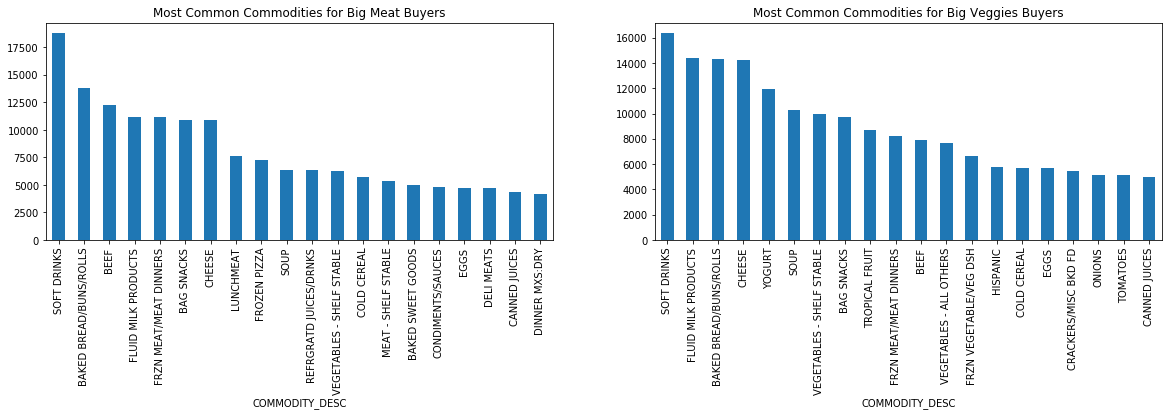

In [65]:
# Look at the 15 most common commodities for each group
top_15_meat = biggest_meat_consumers_transactions.groupby("COMMODITY_DESC")["household_key"]\
                                   .count()\
                                   .sort_values(ascending=False)[:20]
top_15_veggies = biggest_veggie_consumers_transactions.groupby("COMMODITY_DESC")["household_key"]\
                                     .count()\
                                     .sort_values(ascending=False)[:20]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
top_15_meat.plot.bar(ax=axes[0]);
top_15_veggies.plot.bar(ax=axes[1]);
axes[0].set_title("Most Common Commodities for Big Meat Buyers");
axes[1].set_title("Most Common Commodities for Big Veggies Buyers");

We observe in the two plots that although there are some similiraties we also notice some differences. For example, big veggies spenders tend to buy more dairy products (cheese, yogurt, milk) than big meat buyers.

We can compare the 2 groups on some selected commodities :

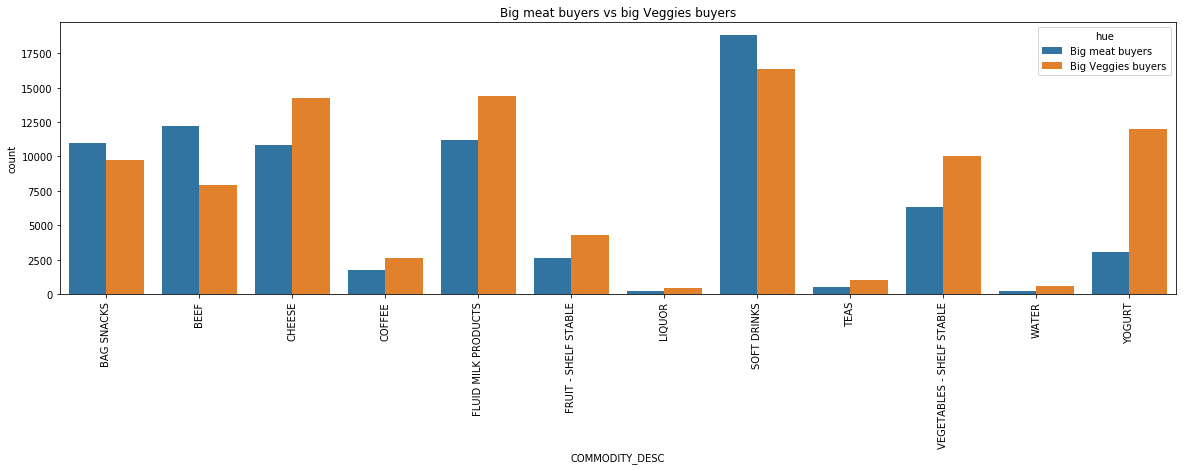

In [66]:
# Compare the 2 groups on some selected commodities
selected_commodities = [
    "FRUIT - SHELF STABLE",
    "SOFT DRINKS",
    "BAG SNACKS",
    "YOGURT",
    "CHEESE",
    "FLUID MILK PRODUCTS",
    "COFFEE",
    "TEAS",
    "VEGETABLES - SHELF STABLE",
    "BEEF",
    "LIQUOR",
    "WATER",
]

def get_count_by_commodity(df, commodities):
    filtered = df[df.COMMODITY_DESC.isin(commodities)]
    return filtered[["COMMODITY_DESC"]].reset_index().groupby("COMMODITY_DESC")["index"].count().reset_index(name="count")

counts_per_commodity_meat = get_count_by_commodity(biggest_meat_consumers_transactions, selected_commodities)
counts_per_commodity_veggies = get_count_by_commodity(biggest_veggie_consumers_transactions, selected_commodities)

counts_per_commodity_meat['hue']="Big meat buyers"
counts_per_commodity_veggies['hue']="Big Veggies buyers"
res=pd.concat([counts_per_commodity_meat, counts_per_commodity_veggies])

plt.figure(figsize=(20,5))
plt.title ("Big meat buyers vs big Veggies buyers")
plot = sns.barplot(x='COMMODITY_DESC',y='count',data=res,hue='hue')
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.show()

Logically, big meat buyers spend more in meat products. As highlighted before, big veggie buyers buy more dairy products, fruits and vegetables.

## Coupons Analysis
Exploratory analysis for the coupon dataset.

In [67]:
df_coupon = pd.read_csv('dunnhumby/coupon.csv', sep = ',')
df_coupon.head()

COUPON_UPC  PRODUCT_ID  CAMPAIGN
0  10000089061       27160         4
1  10000089064       27754         9
2  10000089073       28897        12
3  51800009050       28919        28
4  52100000076       28929        25

In [68]:
df_coupon_redempt = pd.read_csv('dunnhumby/coupon_redempt.csv', sep = ',')
df_coupon_redempt.head()

household_key  DAY   COUPON_UPC  CAMPAIGN
0              1  421  10000085364         8
1              1  421  51700010076         8
2              1  427  54200000033         8
3              1  597  10000085476        18
4              1  597  54200029176        18

In [69]:
print('There are {0} rows and {1} columns in the df_coupon.'.format(len(df_coupon), len(df_coupon.columns)))
print('There are {0} rows and {1} columns in the df_coupon_redempt.'.format(len(df_coupon_redempt), len(df_coupon_redempt.columns)))
print('Number of columns with missing values for df_coupon is {0}.'.format(len(df_coupon.columns.to_numpy()[df_coupon.isna().any()])))
print('Number of columns with missing values for df_coupon_redempt is {0}.'.format(len(df_coupon_redempt.columns.to_numpy()[df_coupon_redempt.isna().any()])))

There are 124548 rows and 3 columns in the df_coupon.
There are 2318 rows and 4 columns in the df_coupon_redempt.
Number of columns with missing values for df_coupon is 0.
Number of columns with missing values for df_coupon_redempt is 0.


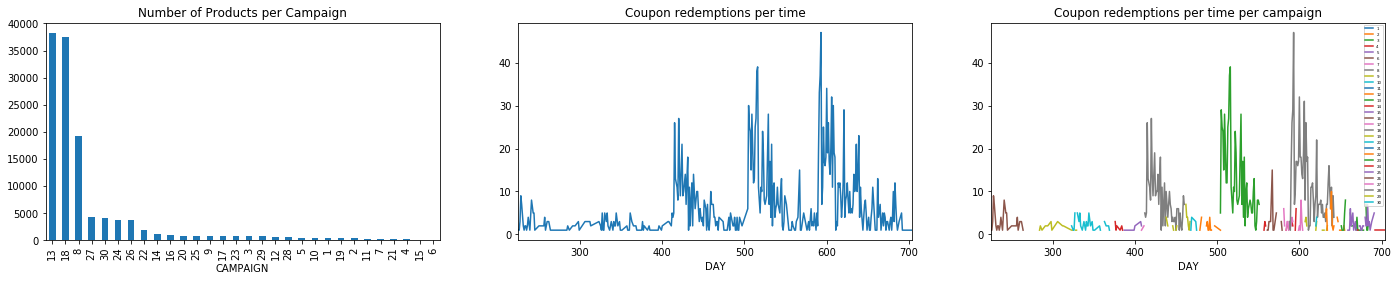

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,4))
df_coupon.groupby('CAMPAIGN')['COUPON_UPC'].count().sort_values(ascending=False).plot.bar(ax=axes[0])
axes[0].set_title("Number of Products per Campaign")

df_coupon_redempt.groupby('DAY')['household_key'].count().plot(ax=axes[1])
axes[1].set_title("Coupon redemptions per time")
df_coupon_redempt.groupby(['CAMPAIGN', 'DAY'])['household_key'].count().reset_index().pivot('DAY', 'CAMPAIGN', 'household_key').plot(ax=axes[2])
axes[2].set_title("Coupon redemptions per time per campaign")
plt.legend(prop={'size': 4});

We observe that there are three campaigns that are distinctively more popular and trending than others, namely, 13, 18 and 8. Those campaigns also last longer (around 75 days) than other campaigns.

As our analysis focusses mainly in food products, we select only the coupons for food products.

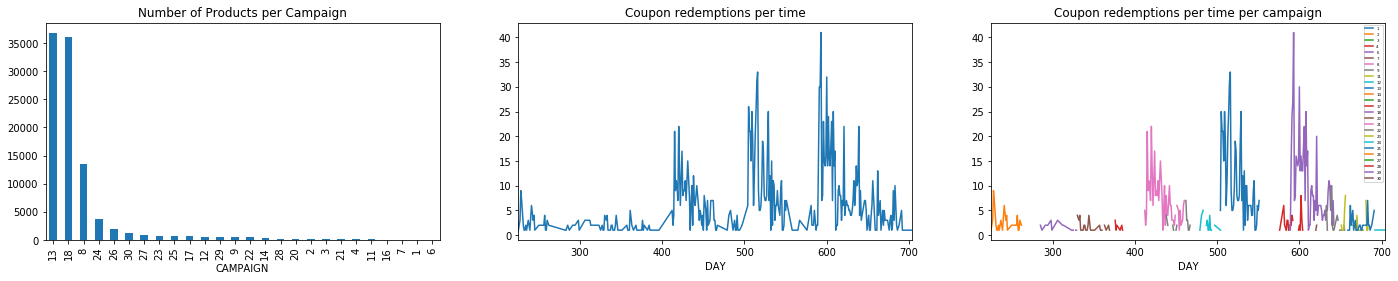

In [71]:
# merge coupon dataframes and filter by food products
df_coupon_and_redempt = pd.merge(df_coupon, df_coupon_redempt, on='COUPON_UPC', how='inner')
df_coupon_and_redempt_for_food = df_coupon_and_redempt[df_coupon_and_redempt.PRODUCT_ID.isin(df_food_products.PRODUCT_ID)]\
    .drop('CAMPAIGN_y', axis=1).rename(columns={'CAMPAIGN_x': 'CAMPAIGN'})
food_coupons = df_coupon_and_redempt_for_food.COUPON_UPC.unique()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,4))
df_coupon[df_coupon.COUPON_UPC.isin(food_coupons)].groupby('CAMPAIGN')['COUPON_UPC'].count().sort_values(ascending=False).plot.bar(ax=axes[0])
axes[0].set_title("Number of Products per Campaign")

df_coupon_redempt[df_coupon_redempt.COUPON_UPC.isin(food_coupons)].groupby('DAY')['household_key'].count().plot(ax=axes[1])
axes[1].set_title("Coupon redemptions per time")
df_coupon_redempt[df_coupon_redempt.COUPON_UPC.isin(food_coupons)].groupby(['CAMPAIGN', 'DAY'])['household_key'].count().reset_index().pivot('DAY', 'CAMPAIGN', 'household_key').plot(ax=axes[2])
axes[2].set_title("Coupon redemptions per time per campaign")
plt.legend(prop={'size': 4});

Furthermore, we observe that most popular three campaigns contain many food coupons. Therefore, they are related with foods.

## Research Focused Analysis

### Relation of Household Demographics and Food Consumption

In this section, we analyse the demographic features and their combined impact on the consumption of different kind of meat and veggie products.

#### Impact of each category on meat consumption

All ratios in the analysis are expressed as the ratio of spendings in the category of interest with respect to the spendings
in food products. 
All the analysis has been confronted with an ANOVA test for equality of means with a 95% confidence interval. 
Only the statistically relevant observations are reported.


In [72]:
df_spent_and_demog=pd.merge(df_household, spent_by_household, on='household_key', how='inner')

In [73]:
def plot_bars(df, demographic_feature, order=None):
    COLS_OF_INTEREST = [
    "avg_spending_per_week",        
    "number_of_active_weeks",
    "avg_spending_ratio_MEAT",
    "avg_spending_ratio_VEGGIE",
    "avg_spending_ratio_PURE_MEAT",
    "avg_spending_ratio_RED_MEAT", 
    "avg_spending_ratio_WHITE_MEAT",
    "avg_spending_ratio_SEA_FOOD",
    ]
    
    rows, cols = 2, 4
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(14,7))
    
    for i, col in enumerate(COLS_OF_INTEREST):    
        chart = sns.barplot(x = demographic_feature, y =col, data = df, ax = axes[i // cols, i % cols], order=order)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

        axes[i // cols, i % cols].set_title(col)
        b, t = axes[i // cols, i % cols].set_ylim() # discover the values for bottom and top
        b -= (t - b)/50 # Add 0.5 to the bottom
        t += (t - b)/10 # Subtract 0.5 from the top
        axes[i // cols, i % cols].set_ylim(b, t) # update the ylim(bottom, top) values
        
    fig.tight_layout()

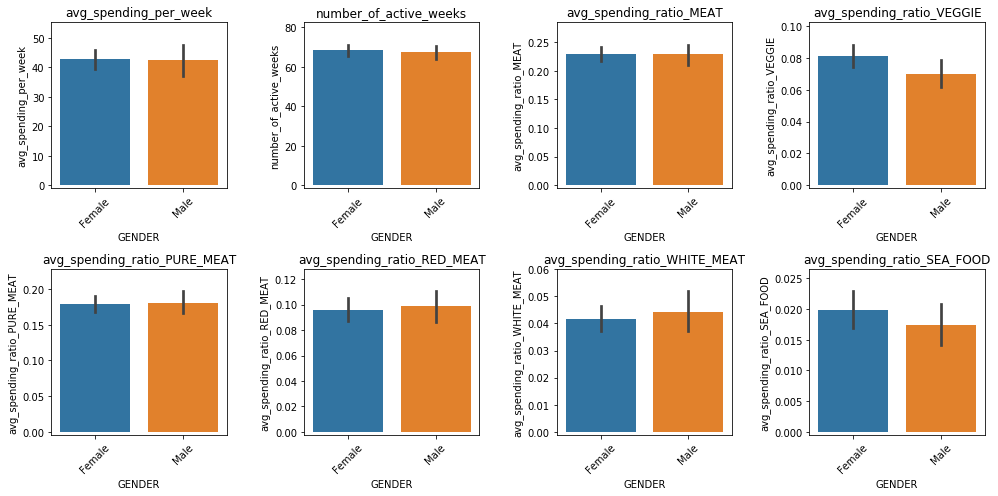

In [74]:
plot_bars(df_spent_and_demog, 'GENDER')

- The only significant difference that we report on gender is in the ratio of vegetables consumption with p value of 0.04 for equality of means. According to our dataset, females consume more vegetables than males.

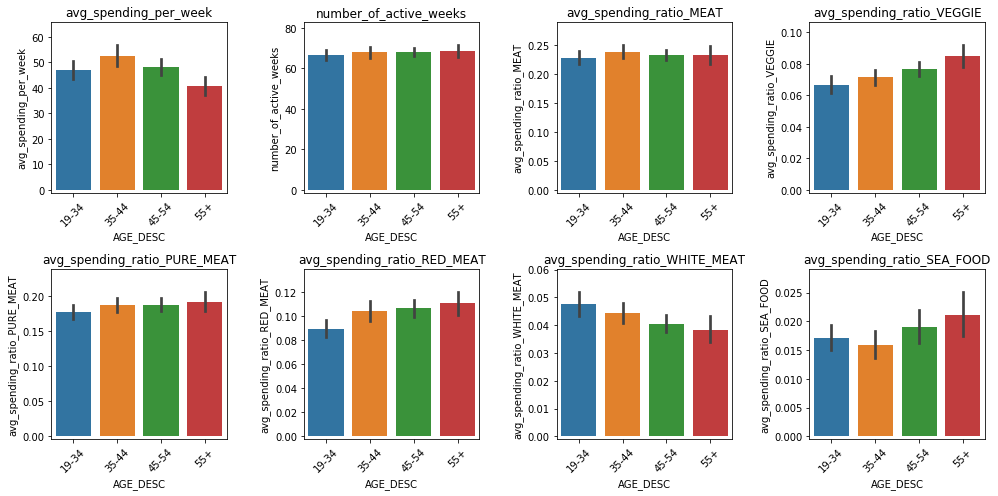

In [75]:
plot_bars(df_spent_and_demog, 'AGE_DESC')

- The food spendings don't seem to follow a clear pattern with respect to the age. 
The youngest consumers seem to spend as much as the 45-54 years old category. 
However, they spend 11\% less than the 35-44 years old category and 13.3\% more than the seniors category.
- There is no significant difference in average ratio of meat (23.3\%), pure meat (18.6\%) and sea products (1.8\%) consumption between age categories (respective p-values are 0.739, 0.264, 0.1 for equality of means).
- The ratio of vegetables and red meat consumption tends to increase with age. We report p values as 0.00, 0.02 for equality of means between youngest and oldest age categories.
While the youngest category spends 6.6% on vegetables, the oldest one spends 8.5\%, representing an increase of 28\%.
A similar observation holds for red meat for which there is a 23.6\% increase between the youngest (8.9\% spendings on red meat) and the oldest category (11%).
- On the other hand, consumption of white meat tends to decrease with age (p values is 0.003 for equality of means between youngest and oldest age category).
While the youngest category spends 4.76\% on white meat, the oldest one spends 3.83\%, representing a decrease of nearly 20\%.

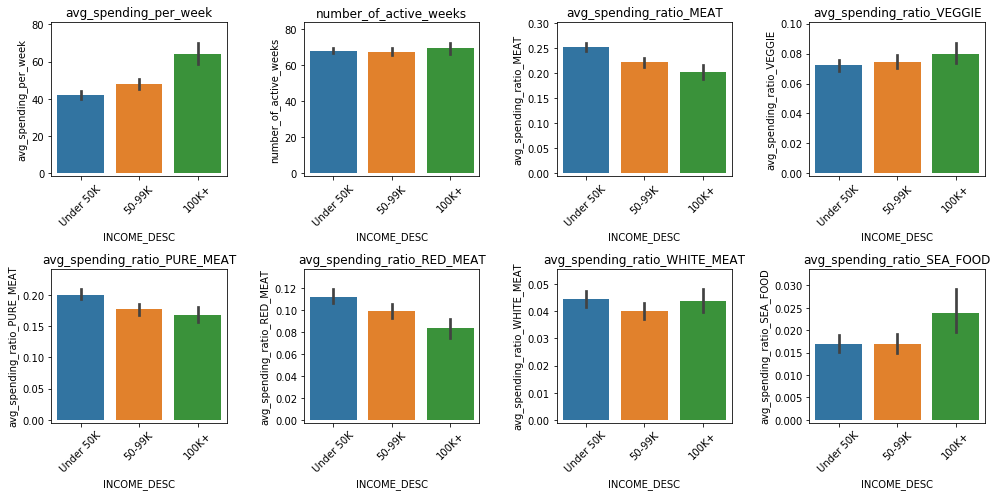

In [76]:
plot_bars(df_spent_and_demog, 'INCOME_DESC')

- There is a significant increase in money spent in food with the household's income (p value is 0.001 for equality of means). 
The wealthiest households (with income higher than 100K \\$) spend as much as 53\% more than the poorest households (with income lower than 35K \\$).
- The ratio of meat and pure meat consumption tends to decrease with levels of income (respective p values are 0.001, 0.001 for equality of means between richest and poorest categories).
While the poorest category spends 25.2\% on meat, the wealthiest one spends 20.2\%, representing a decrease of nearly 20\%.
- There is no significant difference in average ratio of vegetables (7.4\%) and white meat (4.27\%) consumption between income categories (respective p values are 0.13, 0.12 and  for equality of means).
- The ratio of sea products consumption is the same for low and middle income categories. 
While the other categories spend 1.7\% on sea products, the wealthiest one spends 2.4\%, representing an increase of more than 40\%.

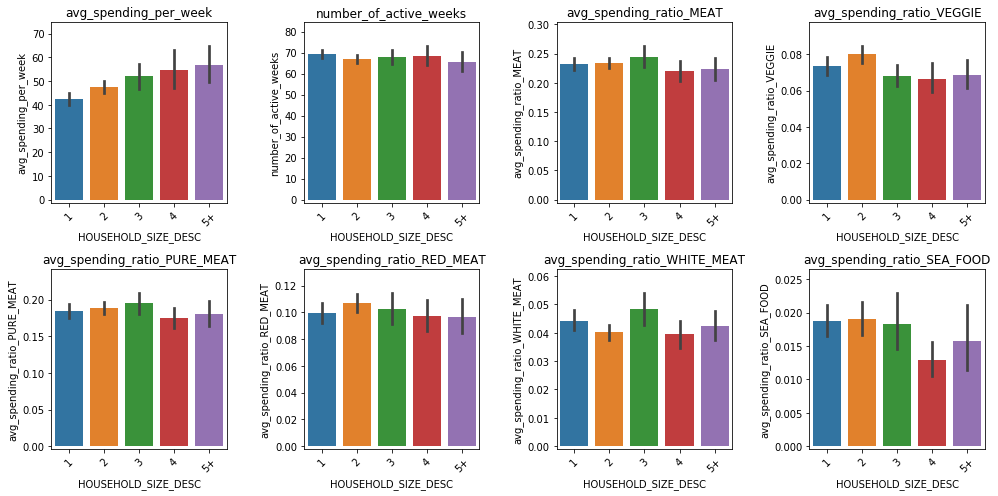

In [77]:
plot_bars(df_spent_and_demog, 'HOUSEHOLD_SIZE_DESC')

- There is an increase of food spendings with the number of persons in the households which is expected. 
There seems to be an increase of 10\% in spendings for each extra household member.
- There is no significant difference in average ratio of any type of meat consumption between household sizes (all p-values are above 0.05 for equality of means for each type of meat).

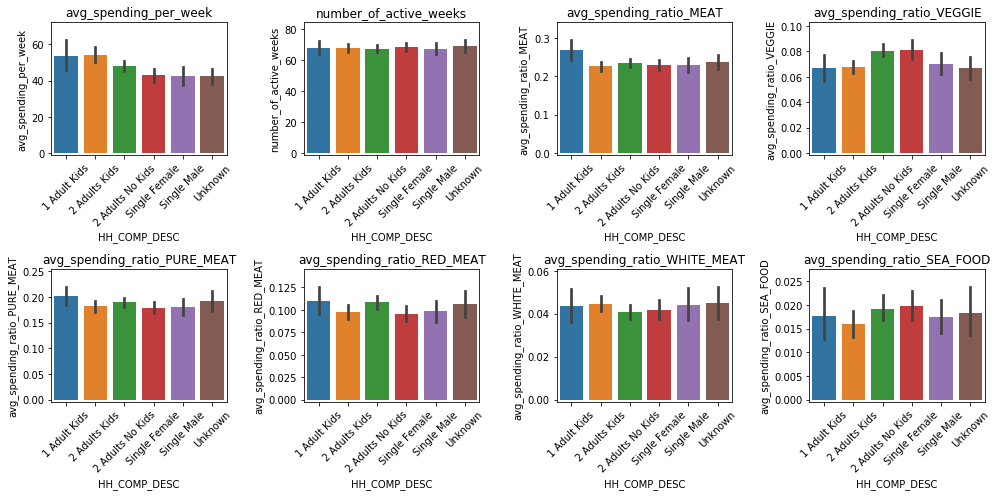

In [78]:
plot_bars(df_spent_and_demog, 'HH_COMP_DESC')

- Food spendings per household increase with the number of adults and the number of kids in it as expected. 
Furthermore, families with kids spend more than other families.
- There is no statistical difference between ratios of meat consumption for the households (p values are all above 0.05 for equality of means for each type of meat).
The same observation is made for every meat category and sea food.
- Single females and 2 adults without kids tend to have a higher vegetables ratio than the others (p value is 0.02 for equality of means). 
These households allocate 8.1\% of their spendings to vegetable against 6.8\% for other households. 
It represents an increase of nearly 20\%.

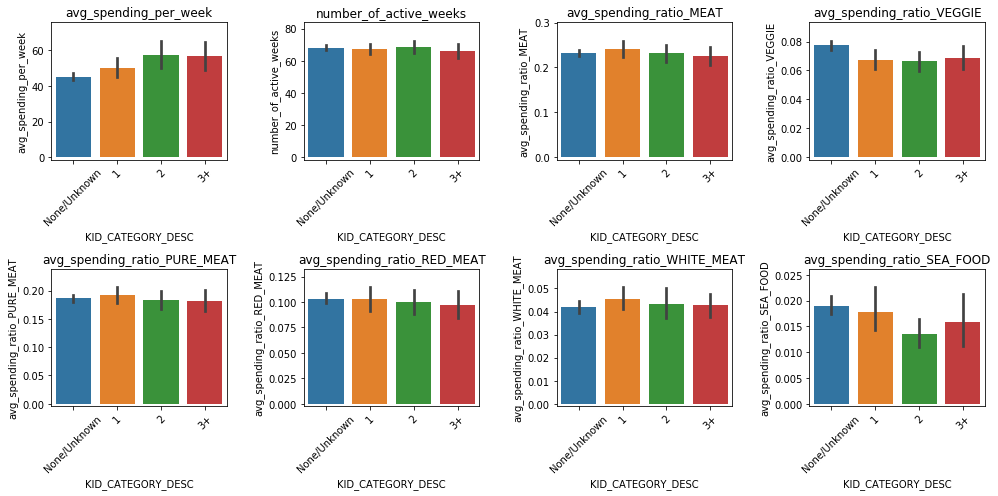

In [79]:
plot_bars(df_spent_and_demog, 'KID_CATEGORY_DESC')

- There is a increase of food spendings with the number of persons in the households, even if households with 2 and more kids seems to spend the same.
- There is no statiscal difference between ratios of meat consumption for the households.
The same observation is made for every meat category (p values are all above 0.05 for equality of means for each type of meat).
- Households without kids seem to spend more in vegetables (p value for equality of means is 0.01).
These households allocate 7.73\% of their spendings to vegetable against 6.75\% for other households. 
It represents an increase of nearly 15\%.

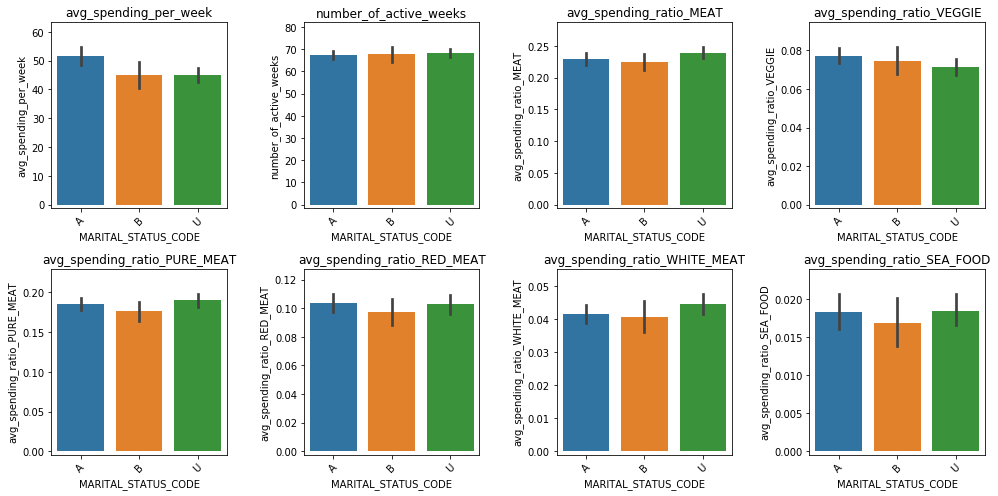

In [80]:
plot_bars(df_spent_and_demog, 'MARITAL_STATUS_CODE')

- Married couples spend more on average per week (p value for equality of means is 0.018). 
- There is no statistical difference between ratios for each product category with respect to marital status (p values are all above 0.05 for equality of means for each product category).

#### Impact of two categories combined on meat consumption

In this subsection, we provide ratio and average consumptions of groups selected by two demographic categories with heatmaps. We look at the average weekly consumptions and ratio of consumptions per group. We report mean and confidence interval (90\%) of each group with yellow-green-blue heatmaps and black-red-yellow maps respectively.

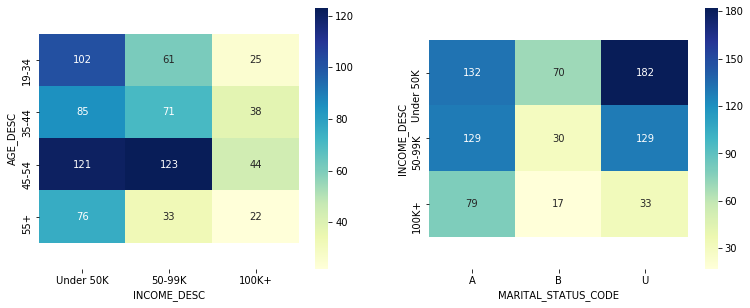

In [81]:
tuples = [
    ('AGE_DESC', 'INCOME_DESC'),
    ('INCOME_DESC', 'MARITAL_STATUS_CODE')]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=default_figsize)

for i, t in enumerate(tuples):
    df_dummy = df_household.groupby([t[0], t[1]]).count()\
        .reset_index().pivot(index= t[0], columns= t[1], values='household_key')
    
    sns.heatmap(df_dummy, annot=True, fmt=".0f", annot_kws={"size": 10}, cmap="YlGnBu", ax=axes[i])
    
    b, t = axes[i].set_ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    axes[i].set_ylim(b, t) # update the ylim(bottom, top) values

Above, we provide the number of households in each group. Representation number decreases as group gets richer.

In [82]:
def plot_heatmap(df_spent_and_demog, KEY, THRESHOLD, COLS_OF_INTEREST, METHOD='mean', fig_size=(10,10)):
    def ci(data, confidence=0.9):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return h
    
    def threshold_groups(df, threshold, KEY):
        valid_indices = df.groupby([KEY[0], KEY[1]]).count()['household_key'] >= threshold
        for k0, k1 in valid_indices.index:
            if not valid_indices[k0][k1]:
                df = df[(df[KEY[0]] != k0) | (df[KEY[1]] != k1)]
        return df

    rows, cols = 1, len(COLS_OF_INTEREST)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=fig_size)

    for i, col in enumerate(COLS_OF_INTEREST):
        
        df_dummy = threshold_groups(df_spent_and_demog, THRESHOLD, KEY)
        if METHOD == 'mean':
            df_dummy = df_dummy.groupby([KEY[0], KEY[1]]).agg({col: 'mean'})\
                                     .reset_index().pivot(index= KEY[0], columns= KEY[1], values=col)
            color = "YlGnBu"

        elif METHOD == 'ci':
            df_dummy = df_dummy.groupby([KEY[0], KEY[1]]).agg({col: ci})\
                                     .reset_index().pivot(index= KEY[0], columns= KEY[1], values=col)
            color = None#'Reds'

        if 'ratio' in col or 'SEA' in col:
            sns.heatmap(df_dummy, annot=True, fmt=".04f", annot_kws={"size": 10}, cmap=color, ax=axes[i])
        elif 'WHITE' in col:
            sns.heatmap(df_dummy, annot=True, fmt=".02f", annot_kws={"size": 10}, cmap=color, ax=axes[i])
        else:
            sns.heatmap(df_dummy, annot=True, fmt=".00f", annot_kws={"size": 10}, cmap=color, ax=axes[i])
            
        axes[i].set_title(col + ' ' + METHOD)
        b, t = axes[i].set_ylim() # discover the values for bottom and top
        b += 0.5 # Add 0.5 to the bottom
        t -= 0.5 # Subtract 0.5 from the top
        axes[i].set_ylim(b, t) # update the ylim(bottom, top) values
    fig.tight_layout()
    
def plot_heatmaps(variables, threshold):
    avg_spending_mean = [
    "avg_spending_per_week",
    "number_of_active_weeks",
    ]

    avg_spending_ratio = [
    "avg_spending_ratio_MEAT",
    "avg_spending_ratio_VEGGIE",
    "avg_spending_ratio_PURE_MEAT",
    "avg_spending_ratio_RED_MEAT", 
    "avg_spending_ratio_WHITE_MEAT",
    "avg_spending_ratio_SEA_FOOD",
    ]
    
    KEY, THRESHOLD = variables, threshold
    plot_heatmap(df_spent_and_demog, KEY=KEY, THRESHOLD=THRESHOLD, COLS_OF_INTEREST=avg_spending_mean, METHOD='mean', fig_size=(7,3.5))
    plot_heatmap(df_spent_and_demog, KEY=KEY, THRESHOLD=0, COLS_OF_INTEREST=avg_spending_mean, METHOD='ci', fig_size=(7,3.5))
    plot_heatmap(df_spent_and_demog, KEY=KEY, THRESHOLD=THRESHOLD, COLS_OF_INTEREST=avg_spending_ratio, METHOD='mean', fig_size=(24.5,3.5))
    plot_heatmap(df_spent_and_demog, KEY=KEY, THRESHOLD=0, COLS_OF_INTEREST=avg_spending_ratio, METHOD='ci', fig_size=(24.5,3.5))

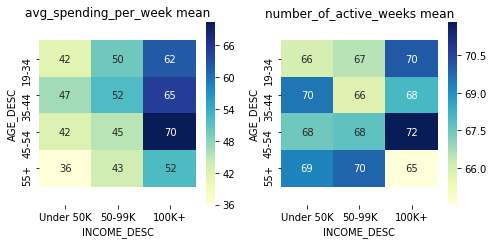

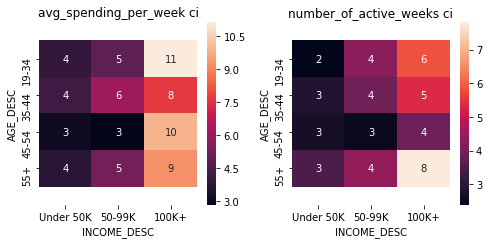

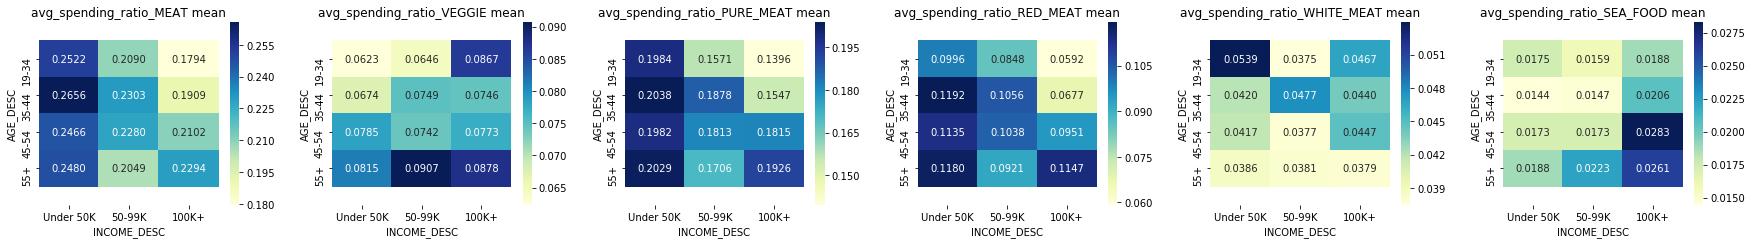

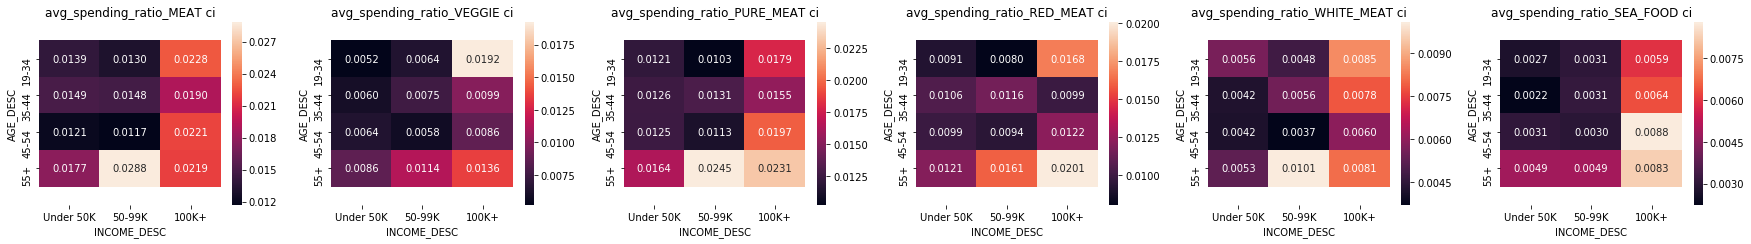

In [83]:
plot_heatmaps(('AGE_DESC', 'INCOME_DESC'), 0)

The observations made for age and income separately are confirmed for the ratio of meat and vegetables consumption. 
However, new observations can be made. Althought we observed that meat consumption significantly does not depend on age, this is not true  for the wealthiest category whom consume more meat as they get older. The same observation is made for seaproducts, who are very popular for richer and older households.

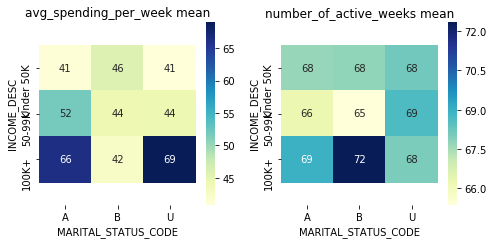

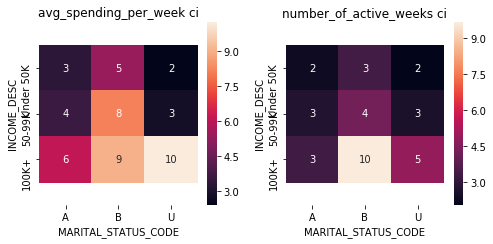

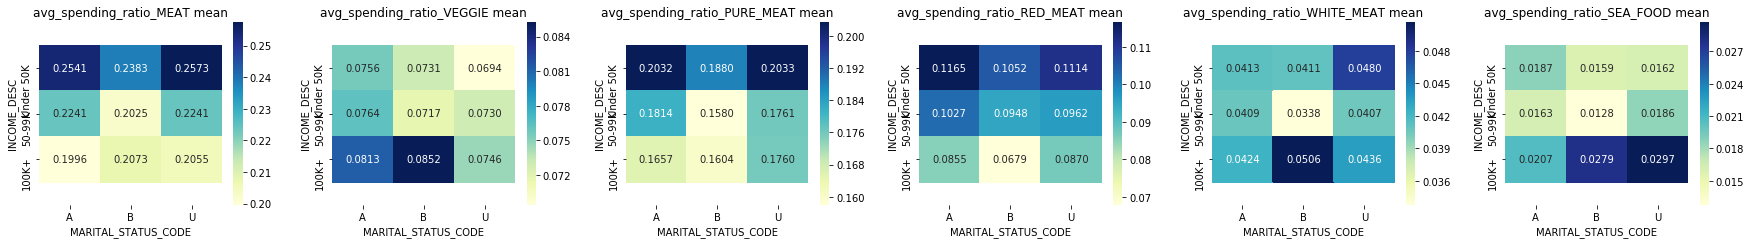

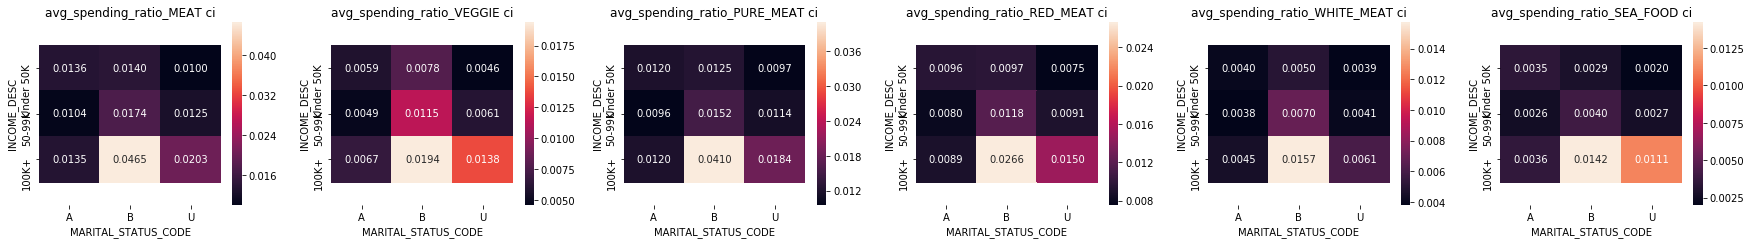

In [84]:
plot_heatmaps(('INCOME_DESC', 'MARITAL_STATUS_CODE'), 0)

- In this analysis, we do not observe an interesting behavior with married and single people with different incomes.

### Time Analysis on Food Consumption

In [85]:
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)

def convert_date_to_season(date_to_convert):
    doy = date_to_convert.timetuple().tm_yday
    if doy in spring:
        return 'spring'
    elif doy in summer:
        return 'summer'
    elif doy in fall:
        return 'fall'
    else:
        return 'winter'

def num_to_month(shortMonth):
    return {
        "01": "Jan",
        "02": "Feb",
        "03": "Mar",
        "04": "Apr",
        "05": "May",
        "06": "Jun",
        "07": "Jul",
        "08": "Aug",
        "09": "Sep",
        "10": "Oct",
        "11": "Nov",
        "12": "Dec",
    }[shortMonth]

df_transactions["SEASON"] = df_transactions.DATE.apply(convert_date_to_season)
df_transactions["MONTH"] = df_transactions.DATE.apply(lambda x: num_to_month(str(x).split("-")[1]))
# To be able to sort by month (January, February, ...)
df_transactions['MONTH'] = pd.Categorical(df_transactions['MONTH'], ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])

For the time analysis we only keep the transactions of 2011 as this is the only full year in the dataset.

In [86]:
## keep only 2011 transactions
df_transactions_2011 = df_transactions[(df_transactions["DATE"] >= "2011-01-01") & (df_transactions["DATE"] < "2012-01-01")]

df_food_transactions_2011 = pd.merge(df_transactions_2011,  df_food_products, on="PRODUCT_ID", how="inner")
df_meat_transactions_2011 = pd.merge(df_meat_products, df_food_transactions_2011, on="PRODUCT_ID", how="inner")
df_veggies_transactions_2011 = pd.merge(df_veggies_products, df_food_transactions_2011, on="PRODUCT_ID", how="inner")

df_pure_meat_transactions_2011 = pd.merge(df_pure_meat, df_food_transactions_2011, on="PRODUCT_ID", how="inner")
df_red_meat_transactions_2011 = pd.merge(df_red_meat, df_food_transactions_2011, on="PRODUCT_ID", how="inner")
df_white_meat_transactions_2011 = pd.merge(df_white_meat, df_food_transactions_2011, on="PRODUCT_ID", how="inner")
df_sea_food_transactions_2011 = pd.merge(df_sea_food, df_food_transactions_2011, on="PRODUCT_ID", how="inner")

In [87]:
num_food_trans_per_season = df_food_transactions_2011.groupby("SEASON")["household_key"]\
                                                     .count()\
                                                     .reset_index(name="count")\
                                                     .set_index("SEASON")


def count_per_season(df, cat):
    df_per_season = df.groupby("SEASON")["household_key"].count().reset_index(name="count").set_index("SEASON")
    df_per_season["FOOD_CAT"] = cat
    df_per_season["RATIO"] = df_per_season["count"] / num_food_trans_per_season["count"]
    df_per_season = df_per_season.reset_index()
    
    return df_per_season

meat_per_season = count_per_season(df_meat_transactions_2011, "MEAT")
pure_meat_per_season = count_per_season(df_pure_meat_transactions_2011, "PURE MEAT")
red_meat_per_season = count_per_season(df_red_meat_transactions_2011, "RED MEAT")
white_meat_per_season = count_per_season(df_white_meat_transactions_2011, "WHITE MEAT")
seafood_per_season = count_per_season(df_sea_food_transactions_2011, "SEAFOOD")
veggies_per_season = count_per_season(df_veggies_transactions_2011, "VEGETABLES")

per_season_food = pd.concat([meat_per_season, pure_meat_per_season, 
                             red_meat_per_season, white_meat_per_season, 
                             seafood_per_season, 
                             veggies_per_season])


#### Seasonal analysis

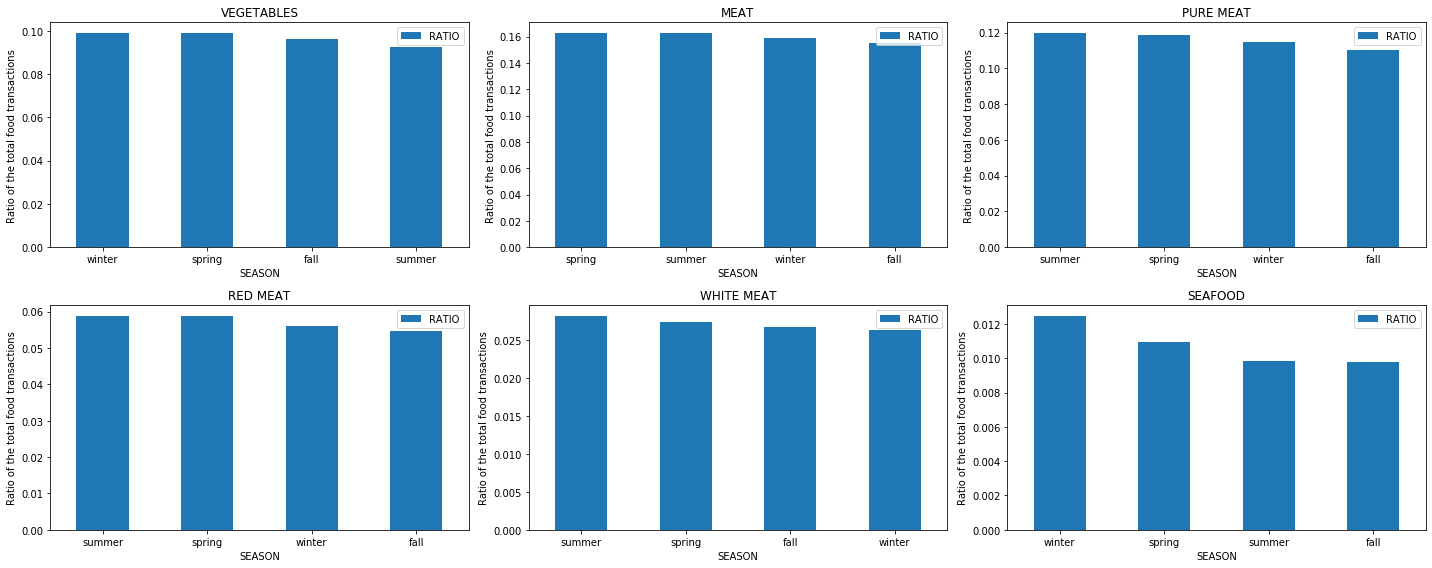

In [88]:
# Plot 
categories = ["VEGETABLES", "MEAT", "PURE MEAT", "RED MEAT", "WHITE MEAT", "SEAFOOD"]

fig, axes = plt.subplots(nrows=2, ncols=len(categories) // 2, figsize=(20,8))
for i, cat in enumerate(categories):
    df = per_season_food[per_season_food["FOOD_CAT"] == cat]
    df.sort_values(by="RATIO", ascending=False).plot.bar(x="SEASON", y="RATIO", ax=axes[i//(len(categories)//2), i%(len(categories)//2)], rot=0)
    axes[i//(len(categories)//2), i%(len(categories)//2)].set_title(cat)
    axes[i//(len(categories)//2), i%(len(categories)//2)].set_ylabel("Ratio of the total food transactions")
plt.tight_layout()

Seafood seems to be more popular in winter than in summer and fall. 

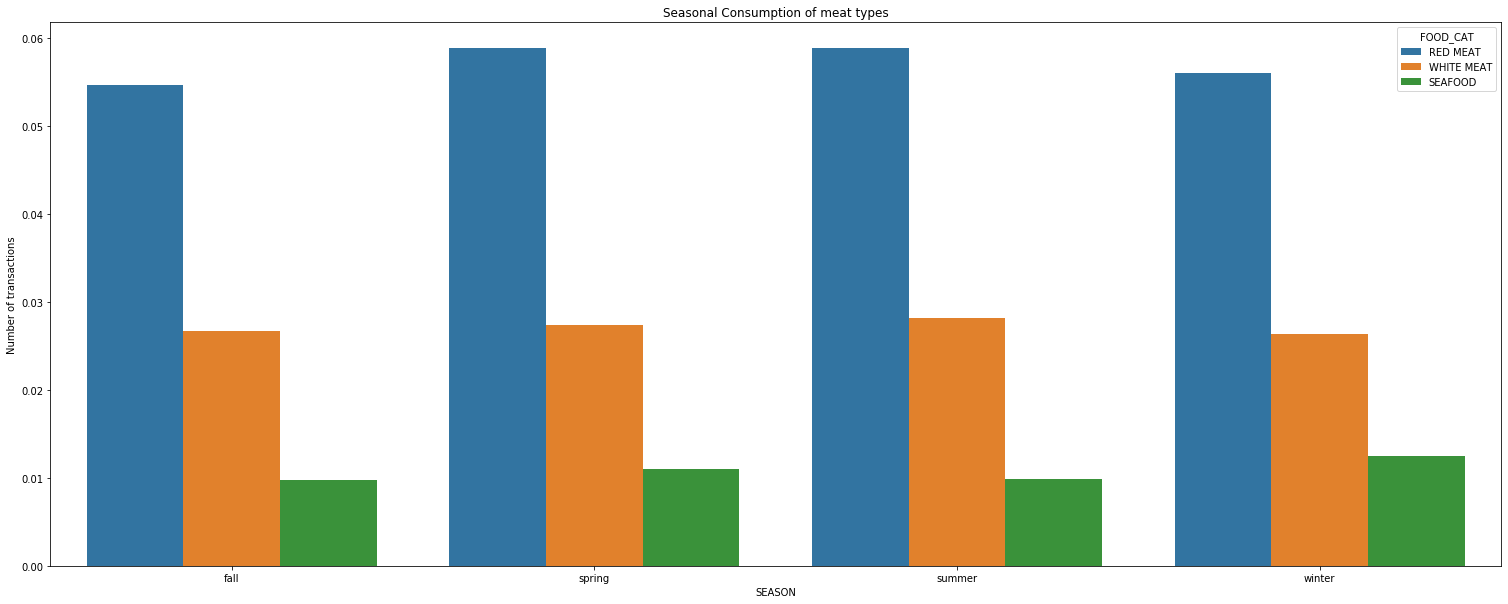

In [89]:
categories = ["RED MEAT", "WHITE MEAT", "SEAFOOD"]
# Plot
plt.figure(figsize=(26, 10))
fig = sns.barplot(x="SEASON", y="RATIO", hue="FOOD_CAT", data=per_season_food, hue_order=categories)
fig.set_title("Seasonal Consumption of meat types");
fig.set_ylabel("Number of transactions");

From the plot above we can see that the order of preference of meat categories stay constant accross season. Red meat is the most sold meat accross all seasons followed by white meat and seafood 

#### Monthly analysis

We will now analyse the evolution of consumption habits on a month scale. We are interested in looking at the evolution of food consumption in general but also at the evolution of meat and vegetables.

In [90]:
def filter_and_count_transaction(df, filter_term, column, time_scale):
    filtered_transactions = df[df[column].str.contains(filter_term)]
    trans_per_day = filtered_transactions.groupby(time_scale)["household_key"].count().reset_index(name="count").reset_index()
    return trans_per_day

def add_ratio(df):
    df["RATIO"] = df["count"] / df["count"].sum()
    return df
    
time = "MONTH"
trans_per_time = {}

food_categories= [
    ("MEAT", df_meat_transactions_2011),
    ("FOOD", df_food_transactions_2011),
    ("VEGETABLES", df_veggies_transactions_2011),
    ("WHITE MEAT", df_white_meat_transactions_2011),
    ("RED MEAT", df_red_meat_transactions_2011),
    ("SEAFOOD", df_sea_food_transactions_2011),    
]

particular_products = [
    ("TURKEY", df_meat_transactions_2011, "COMMODITY_DESC_x"),
    ("PUMPKIN", df_food_transactions_2011, "SUB_COMMODITY_DESC"),
]

# Food, Meat, Veggies
for food_type, df in food_categories:
    trans_per_time[food_type] = df.groupby(time)["household_key"]\
                                                    .count().reset_index(name="count")\
                                                    .reset_index()
    trans_per_time[food_type] = add_ratio(trans_per_time[food_type])

# Particular products
for product, df, column in particular_products:
    trans_per_time[product] = filter_and_count_transaction(df, product, column, time)
    trans_per_time[product] = add_ratio(trans_per_time[product])

In [91]:
fig = go.Figure()
for name, df in zip(trans_per_time.keys(), trans_per_time.values()):
    fig.add_scatter(x=df[time], y=df['RATIO'], name=name)

fig.update_layout(
    title="Ratio between the number of transactions during the month and the total number of transactions by category",
    title_x=0.5,
    yaxis_title="Ratio",
    xaxis_title="Month",
)
fig.show()

We observe that for food, meat and vegetables in general, the monthly consumption does not vary. However, some variations can be observed when looking at specific types of meats or vegetables. Indeed, looking only at turkeys, we observe a peak in November. This can be explain by Thanksgiving which takes place in November. On the vegetable side, we can observe a peak for pumpkins which coincides with Halloween. 

#### Daily analysis

We are also interested in looking at the comsumtion of the meat categories on a daily scale. We do not consider Ovine meat here as the number of transactions is very limited.

In [92]:
categories = ["FOOD", "MEAT", "VEGETABLE", "PURE MEAT", "RED MEAT", "WHITE MEAT", "SEAFOOD"]
fig = make_subplots(rows=7, cols=1, subplot_titles=categories)
dfs = [df_food_transactions_2011,
    df_meat_transactions_2011,
    df_veggies_transactions_2011,
    df_pure_meat_transactions_2011,
    df_red_meat_transactions_2011,
    df_white_meat_transactions_2011,
    df_sea_food_transactions_2011]

for i, df in enumerate(dfs):
    df = df.groupby("DATE")["household_key"].count().reset_index(name="count").reset_index()
    fig.add_trace(
    go.Scatter(x=df.DATE, y=df["count"], name=categories[i]),
    row=i + 1, col= 1 
    )
    fig.update_yaxes(title_text="Number of transactions", row=i+1, col=1)
fig.update_layout(height=1200)
fig.show()

On the daily scale, we do not observe interesting variations as it is very noisy compared to the seasonal analysis. The only exception is seafood, for which we see two peaks in the graph. The first is around Christ

#### Analysis of Popularity of product in Different Groups of Households

In [93]:
# Get pure meat transactions
pure_meat_transactions = pd.merge(df_transactions,df_pure_meat, on = "PRODUCT_ID", how = "inner")
pure_meat_transactions_type = pure_meat_transactions.groupby("MEAT_TYPE").agg({"PAID_PRICE" : sum})

##### Extreme Meat Consumers vs Extreme Vegetable Consumers

In [121]:
def get_transactions_and_ıds_ın_quantıle(spending_type, quantile):
    '''
    Get the transactions and households ıds of the extreme consumers
    A consumer ıs consıdered extreme ıf ıt ıs ın the 'quantile' quantıle
    '''
    quantile = spending_type.quantile(quantile)
    households = spent_by_household[spending_type > quantile].household_key.values
    transactions = df_food_transactions[df_food_transactions.household_key.isin(households)]
    transactions_with_prod_info = pd.merge(transactions, df_products, how="inner")    
    return list(households), transactions_with_prod_info

def describe_meat_consumption(households_ids, households_transactions, category):
    """
    According to the IDs and Transactions of a group a Household (e.g. Extreme meat eaters)
    Show: 
      - their spendings foe each type of meat
      - For each of the meat type, the ration that they consume
    """
    
    # Select only transactions for pure meat producs
    meat_transactions = pd.merge(households_transactions, df_pure_meat, on = "PRODUCT_ID", how = "inner")
    # Compute sum of paid price
    meat_type = meat_transactions.groupby("MEAT_TYPE").agg({"PAID_PRICE" : sum})
    # Compute Ratio spent per meat type
    ratio_meat = meat_type.copy()
    ratio_meat.PAID_PRICE = ratio_meat.PAID_PRICE/pure_meat_transactions_type.PAID_PRICE
    ratio = sum(meat_type.PAID_PRICE)/sum(pure_meat_transactions_type.PAID_PRICE)
    ratio_meat.rename(columns={'PAID_PRICE':'Fraction consumed by {} per meat type'.format(category)}, inplace=True)
    # Plot
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
    meat_type.sort_values(by = 'PAID_PRICE',ascending = False).plot.bar(ax = axes[0])
    ratio_meat.sort_values(by = 'Fraction consumed by {} per meat type'.format(category),ascending = False).plot.bar(ax = axes[1]);
#     axes[1].axhline(y=ratio,linewidth=2, color='red', label = 'Ratio of meat spending for the {}'.format(category))
    axes[1].set_title('Ratio between money spent in meat overall and for {}'.format(category))
    axes[1].set_title('Ratio of meat spending for the {}'.format(category))
    axes[0].set_title('Money spent on meat by {}'.format(category))
    
    # Select only transactions of extreme meat consumers for Veggies producs
    transactions_veggie = pd.merge(households_transactions, df_veggies_products, on = "PRODUCT_ID", how = "inner")

    # Check prcts spent for meat and veggies
    prct_vegg = sum(transactions_veggie.PAID_PRICE)/sum(households_transactions.PAID_PRICE)
    prct_meat = sum(meat_transactions.PAID_PRICE)/sum(households_transactions.PAID_PRICE)
    print('Percentage of total money spent on meat {0:.2f} and on vegetables {1:.2f}.'.format(100*prct_meat,100*prct_vegg))
    print()
    
def compare_two_groups(group1, group2, column, top=20):
    """
    Return the the Top 15 most common sub commodities or commodities (depending on the colum arg.)
    for each of the 2 groups.
    And plot it.
    """
    
    group1_df, group1_name = group1
    group2_df, group2_name = group2
 
    top_20_g1 = group1_df.groupby(column)["PAID_PRICE"]\
                                       .sum()\
                                       .sort_values(ascending=False)[:top]
    top_20_g2 = group2_df.groupby(column)["PAID_PRICE"]\
                                         .sum()\
                                         .sort_values(ascending=False)[:top]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
    top_20_g1.plot.bar(ax=axes[0]);
    top_20_g2.plot.bar(ax=axes[1]);
    axes[0].set_title("Most Common {} for {}".format(column, group1_name));
    axes[1].set_title("Most Common {} for {}".format(column, group2_name));
    
    return top_20_g1, top_20_g2

def make_word_cloud(words, top20, color):
    """
    Return a word cloud containing the words
    that are in the the top20 and in the arg. words.
    """
    filtered_words = []
    for sub_commodity, value in zip(top20.index, top20):
        value = round(value)
        words = sub_commodity.strip().split(" ")
        for word in words:

            if word in interesting_words:
                if word == "FRZN": word = "FROZEN"
                if word == "CHICK": word = "CHICKEN"
                if word == "BEERALEMALT": word = "BEER"
                if word == "SEAFOOD-FRZ-IQF": word = "SEAFOOD"
                for _ in range(value):
                    filtered_words.append(word)
    wordcloud = WordCloud(background_color='white', color_func=lambda *args, **kwargs: color, width=1000, height=500, collocations = False)
    return wordcloud.generate(" ".join(filtered_words))

def plot_word_clouds(intersesting_words, words1, words2, colors):
    """
    Plot a Word Cloud.
    """
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10))

    wordcloud_meat = make_word_cloud(interesting_words, words1, colors[0])
    wordcloud_veggies = make_word_cloud(interesting_words, words2, colors[1])

    axes[0].imshow(wordcloud_meat)
    axes[1].imshow(wordcloud_veggies)
    axes[0].axis('off')
    axes[1].axis('off')
    
selected_commodities = list(df_food_products.COMMODITY_DESC.unique())[:30]

def get_transactions(transactions_df, households_keys):
    """
    Returns the of the households in households_keys transactions from transactions_df
    """
    transactions = transactions_df[transactions_df.household_key.isin(households_keys)]
    transactions = pd.merge(transactions, df_products, how="inner") 
    return transactions

def get_count_by_commodity(df, commodities):
    filtered = df[df.COMMODITY_DESC.isin(commodities)]
    return filtered[["COMMODITY_DESC"]].reset_index().groupby("COMMODITY_DESC")["index"].count().reset_index(name="count")

def compare_groups_on_selected_commodidies(g1_transactions, g2_transactions, g1_name, g2_name, g1_size, g2_size):
    '''
    Plot the number of transactıons per household of two groups of households
    for some selected commodıtıes
    '''
    counts_per_commodity_g1 = get_count_by_commodity(g1_transactions, selected_commodities)
    counts_per_commodity_g2 = get_count_by_commodity(g2_transactions, selected_commodities)
    counts_per_commodity_g1["Number of transaction per household"] = counts_per_commodity_g1["count"]/g1_size
    counts_per_commodity_g2["Number of transaction per household"] = counts_per_commodity_g2["count"]/g2_size

    counts_per_commodity_g1['hue'] = g1_name
    counts_per_commodity_g2['hue'] = g2_name
    res=pd.concat([counts_per_commodity_g1, counts_per_commodity_g2])

    plt.figure(figsize=(20,5))
    plt.title ("{} vs {}".format(g1_name, g2_name))
    plot = sns.barplot(x='COMMODITY_DESC',y='Number of transaction per household',data=res,hue='hue')
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    plt.show()

We have decided to consider only the extreme meat and vegetables consumers as those belonging to the .95 quantile of spendings for each group. This will allow to consider which products do they buy the most and from which categories.

Percentage of total money spent on meat 38.43 and on vegetables 6.03.



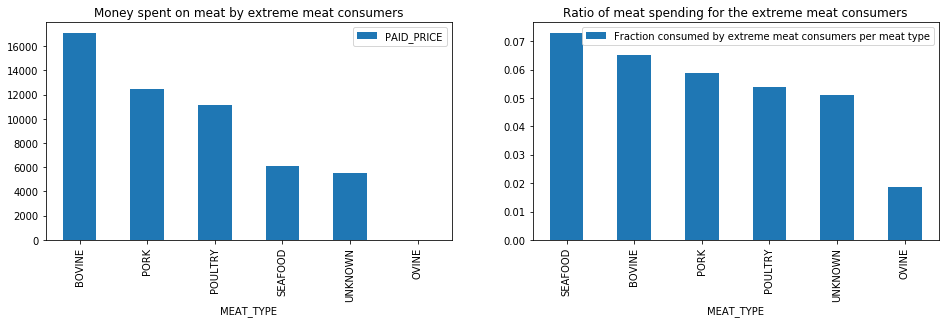

In [119]:
# Get extreme meat consumers transactions and households IDs
extreme_meat_consumers, extreme_meat_consumers_transactions = get_transactions_and_ıds_ın_quantıle(spent_by_household.avg_spending_ratio_MEAT,
                                                                               quantile=0.95
                                                                              )
describe_meat_consumption(extreme_meat_consumers, extreme_meat_consumers_transactions, "extreme meat consumers")

It can be clearly see that bovine meat is the most popular amongst the consumers, accounting for 30% of the meat spendings. Poultry and pork meat have a very similar spending average, accounting each for 25% of the overall. The less popular meat category is ovine meat with 0.1% of the spendings. We see that extreme meat eaters contribute most to the consumption of seafood with more than 7% of the overall consumption.

Percentage of total money spent on meat 17.18 and on vegetables 16.93.



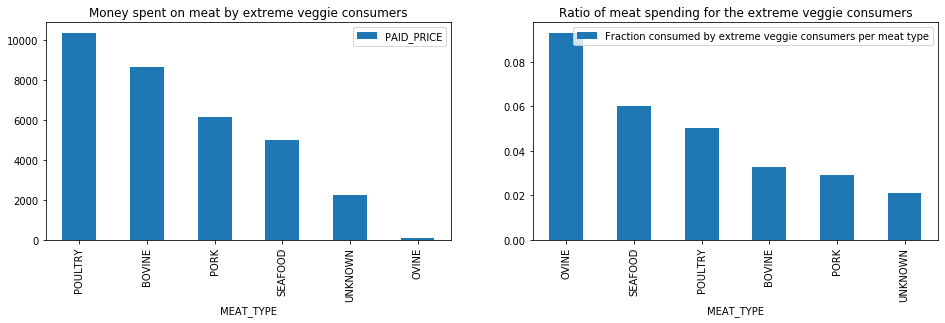

In [96]:
# Get extreme veggies consumers transactions and households IDs
extreme_veggie_buyers, extreme_veggie_consumers_transactions = get_transactions_and_ıds_ın_quantıle(
    spent_by_household.avg_spending_ratio_VEGGIE, quantile=0.95)

describe_meat_consumption(extreme_veggie_buyers, extreme_veggie_consumers_transactions, "extreme veggie consumers")

We can see that poultry is much more popular in extreme vegetables consumers than in extreme meat consumers. Moreover, ovine and seafood are the categories for which they account for the biggest marketshare.

In [97]:
households_in_both = list(set(extreme_meat_consumers).intersection(extreme_veggie_buyers))
print(f"Out of those {len(extreme_veggie_buyers)} household, {len(households_in_both)} of them (={round((len(households_in_both) / len(extreme_meat_consumers)) * 100, 2)}%) are both extreme meat buyers and extreme veggies buyers.")

Out of those 98 household, 1 of them (=1.02%) are both extreme meat buyers and extreme veggies buyers.


We only consider households that appear in one of the two groups. Doing that we have two disting groups of people.

In [98]:
# Remove houselds that are in the two groups
extreme_meat_consumers_transactions = extreme_meat_consumers_transactions[~extreme_meat_consumers_transactions.household_key.isin(households_in_both)]
extreme_veggie_consumers_transactions = extreme_veggie_consumers_transactions[~extreme_veggie_consumers_transactions.household_key.isin(households_in_both)]

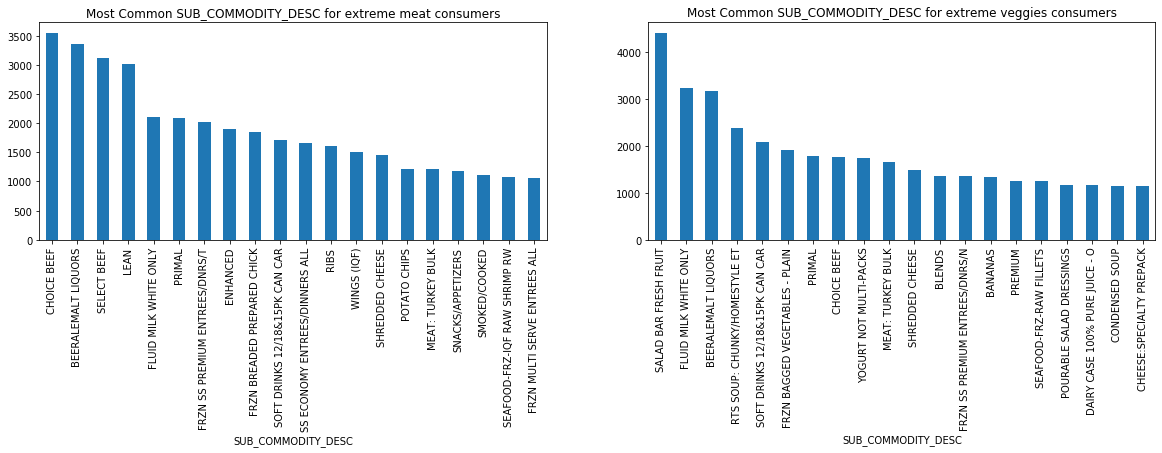

In [99]:
top_20_meat, top_20_veggies = compare_two_groups(
    (extreme_meat_consumers_transactions, "extreme meat consumers"),
    (extreme_veggie_consumers_transactions, "extreme veggies consumers"),
    "SUB_COMMODITY_DESC"
)

20 most common SUB_COMMODITY_DESC for extreme meat consumers and extreme veggies consumers is shown above. We can see that amongst the top 5 most common products for extreme meat buyers 3 of them are beef products while none of the top 5 products are meat for the extreme vegetable buyers, who have fruit and soup in their top 5.

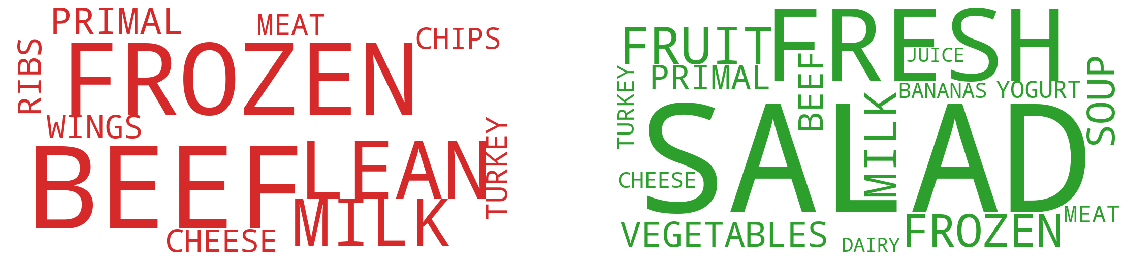

In [100]:
interesting_words = ['BEEF', 'TORTILLALIQUORS', 'LEAN', 'MILK', 'PRIMAL', 'FRZN', 'RIBS', 'WINGS', 'CHEESE', 'CHIPS', 'SNACKS', 'TURKEY', 'BREAD', 'SALAD', 'FRESH', 'FRUIT', 'SOUP:', 'MEAT:', 'VEGETABLES', 'CAN', 'YOGURT', 'BANANAS', 'DAIRY', 'TOMATOES', 'CUCUMBERS', 'JUICE']
plot_word_clouds(interesting_words, top_20_meat, top_20_veggies, colors=["rgb(214, 41, 42)", "rgb(45, 159, 45)"])

As expected, the most popular words for extreme meat consumers are related to meat as beef, lean, primal, wings or ribs while for extreme vegetables consumers these are salad, vegetables and fruit. It is interesting to see that the second most common word is frozen for the meat consumers and fresh for the vegetable consumers. It shows a great opposition between both.

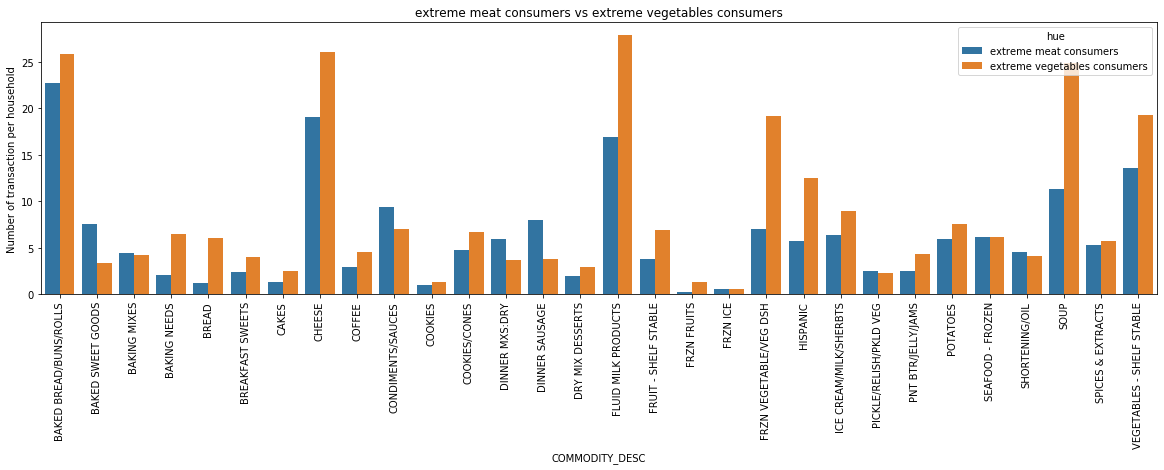

58424
84642


In [125]:
compare_groups_on_selected_commodidies(extreme_meat_consumers_transactions, extreme_veggie_consumers_transactions, "extreme meat consumers", "extreme vegetables consumers", len(extreme_meat_consumers), len(extreme_veggie_buyers))
print(len(extreme_meat_consumers_transactions.PRODUCT_ID))
print(len(extreme_veggie_consumers_transactions.PRODUCT_ID))

As expected meat related COMMODITY_DESC are much more popular in extreme meat buyers. It is less expected to see categories as hispanic or baking needs much more popular between extreme vegetables buyers.

##### Old Households vs Young Households

This part will focus on the most consumed products depending on age and comparing the youngest category (19 to 34 years old) to the elderest (55+ years old).

In [102]:
young_houeholds_keys = df_household[df_household.AGE_DESC == '19-34'].household_key.values
old_houeholds_keys = df_household[df_household.AGE_DESC == '55+'].household_key.values

In [103]:
young_consumers_transactions = get_transactions(df_food_transactions, young_houeholds_keys)
old_consumers_transactions = get_transactions(df_food_transactions, old_houeholds_keys)

young_consumers_meat_transactions = get_transactions(df_pure_meat_transactions, young_houeholds_keys)
old_consumers_meat_transactions = get_transactions(df_pure_meat_transactions, old_houeholds_keys)

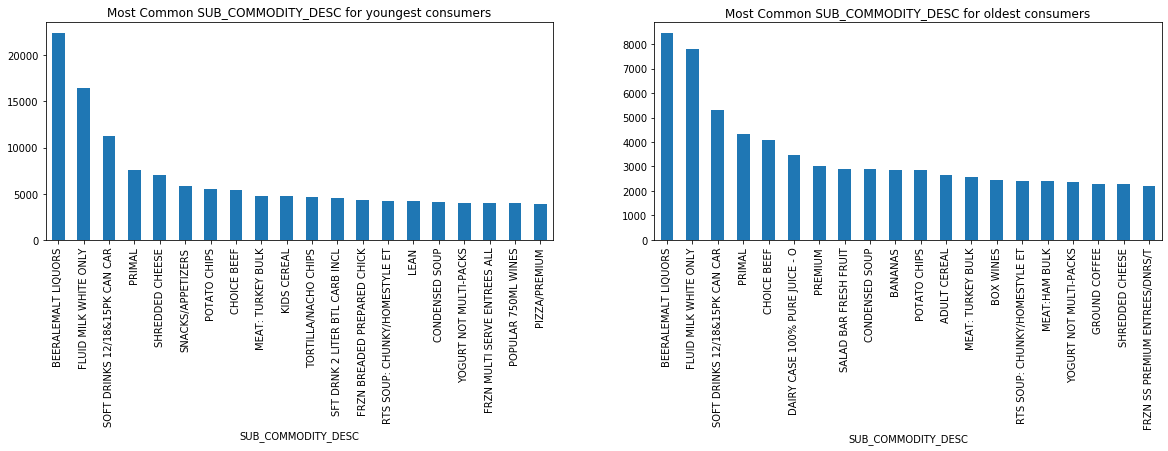

In [104]:
top_20_youngs, top_20_olds = compare_two_groups(
    (young_consumers_transactions, "youngest consumers"),
    (old_consumers_transactions, "oldest consumers"),
    "SUB_COMMODITY_DESC"
)

We see that there aren't many differences between age categories for the most bought products as the 4 first subcommodities are the same.

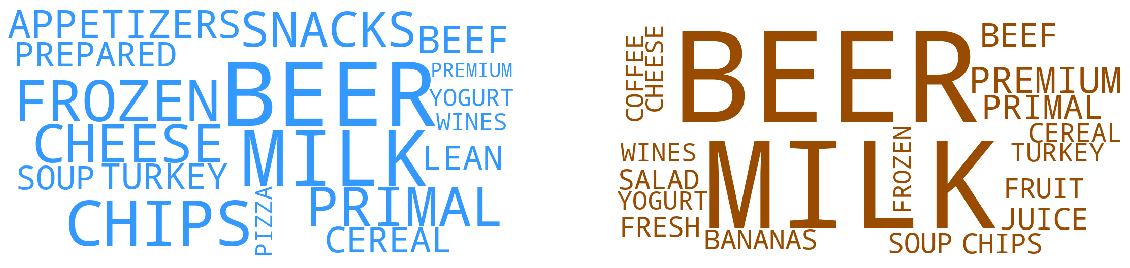

In [105]:
interesting_words = ['BEERALEMALT', 'MILK', 'CAN', 'PRIMAL', 'CHEESE', 'SNACKS/APPETIZERS', 'CHIPS', 'BEEF', 'TURKEY', 'CEREAL', 'PREPARED', 'SOUP', 'YOGURT', 'FRZN', 'LEAN', 'WINES', 'PIZZA/PREMIUM', 'JUICE', 'PREMIUM', 'SALAD', 'FRESH', 'FRUIT', 'BANANAS', 'TURKEY', 'HAM', 'COFFEE']
plot_word_clouds(interesting_words, top_20_youngs, top_20_olds, colors=["rgb(51, 153, 255)", "rgb(153, 76, 0)"])

When we see the word clouds, some differences can be clearly seen. First of all, the youngest category seems to have more unhealthy habits with chips, snacks, appetizers and frozen being amongst the most popular words while the oldest category has words as soup, fruit, bananas, fresh, juice and salad amongst the most popular words.

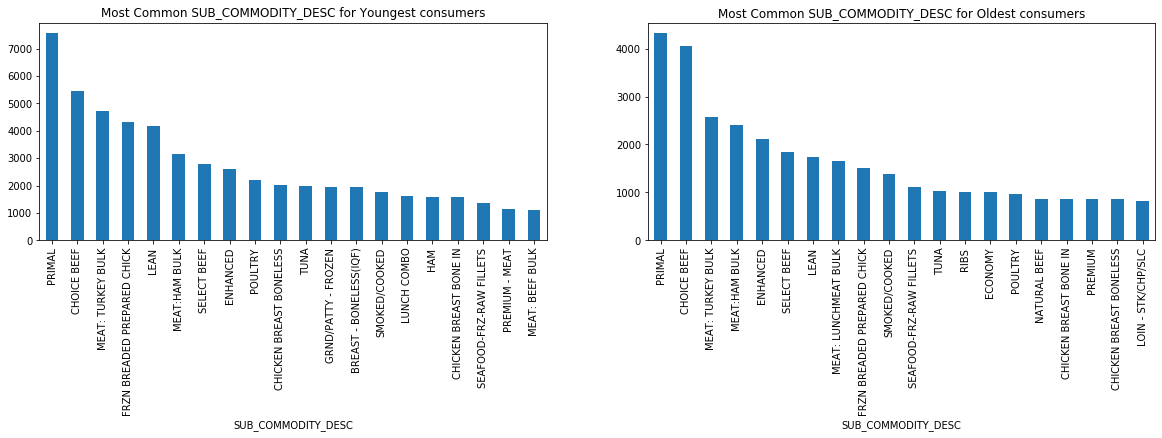

In [106]:
top_20_youngs_meat, top_20_olds_meat = compare_two_groups(
    (young_consumers_meat_transactions, "Youngest consumers"),
    (old_consumers_meat_transactions, "Oldest consumers"),
    "SUB_COMMODITY_DESC"
)

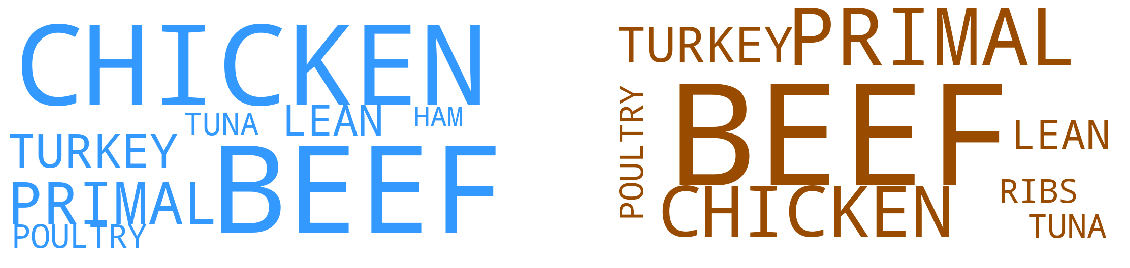

In [107]:
interesting_words=['PRIMAL', 'BEEF', 'TURKEY', 'CHICK', 'LEAN', 'HAM', 'BEEF', 'POULTRY', 'CHICKEN', 'TUNA', 'RIBS']
plot_word_clouds(interesting_words, top_20_youngs_meat, top_20_olds_meat, colors=["rgb(51, 153, 255)", "rgb(153, 76, 0)"])

There aren't many differences between the two categories in terms of meat consumption. We have already seen that the youngest category eat more poultry than the oldest one. This is confirmed by the importance of the word chicken in the two categories.

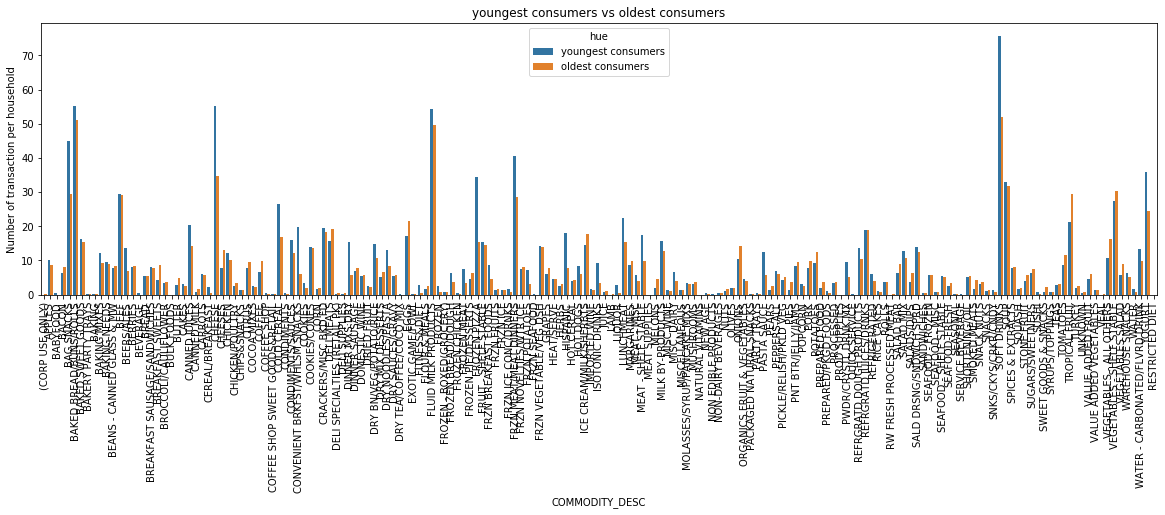

In [108]:
compare_groups_on_selected_commodidies(young_consumers_transactions, old_consumers_transactions, "youngest consumers", "oldest consumers", len(young_houeholds_keys), len(old_houeholds_keys))

This last graph confirms what has been said before as youngest consumers tend to buy more bag snacks and frozen meat dinners than the oldest group. They also tend to eat much more dry dinner mixes and hispanic. Older households don't seem to have a food category where they buy much more.

##### Rich Households vs Poor Households

This part will focus on the most consumed products depending on the income and compares the poorest category (income below 50K) to the wealthiest (income above 100K).

In [109]:
poor_households_keys = df_household[df_household.INCOME_DESC == 'Under 50K'].household_key.values
rich_households_keys = df_household[df_household.INCOME_DESC == '100K+'].household_key.values

In [110]:
poor_consumers_transactions = get_transactions(df_food_transactions, poor_households_keys)
rich_consumers_transactions = get_transactions(df_food_transactions, rich_households_keys)

poor_consumers_meat_transactions = get_transactions(df_pure_meat_transactions, poor_households_keys)
rich_consumers_meat_transactions = get_transactions(df_pure_meat_transactions, rich_households_keys)

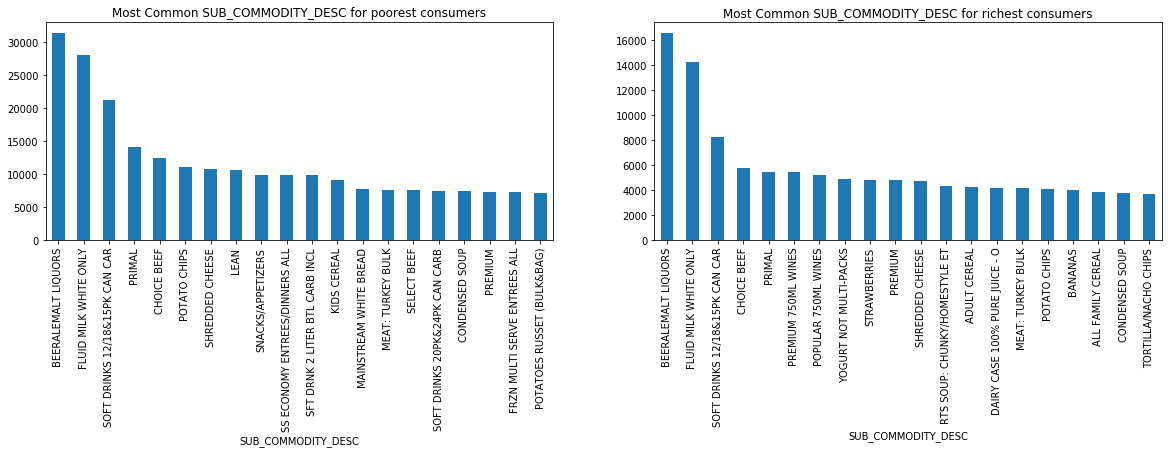

In [111]:
top_20_poor, top_20_rich = compare_two_groups(
    (poor_consumers_transactions, "poorest consumers"),
    (rich_consumers_transactions, "richest consumers"),
    "SUB_COMMODITY_DESC"
)

The top 5 products are the same for both categories. However, in the top 10 subcommodities, snacks appear twice for the poorest households while wine appears twice for the wealthiest ones. Wine is often seen as a luxury product so that this analysis makes sense.

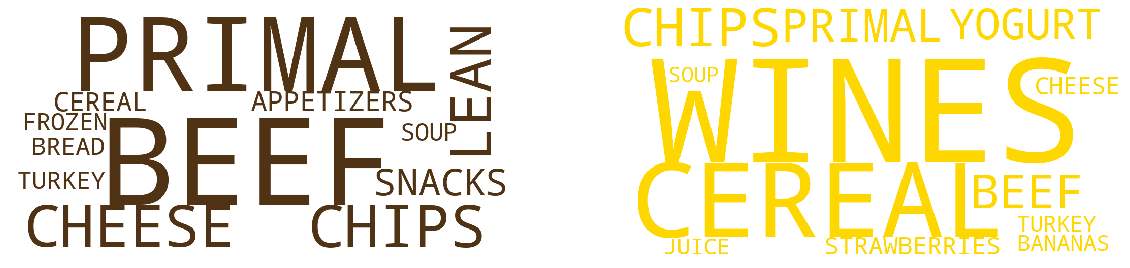

In [112]:
interesting_words = ['PRIMAL', 'BERRALEMALT', 'MILL', 'CAN', 'PRIMAL', 'CHEESE', 'BEEF', 'CHIPS', 'LEAN', 'CEREAL', 'FRZN', 'SNACKS/APPETIZERS', 'TURKEY', 'BREAD', 'SOUP', 'BANANAS', 'WINES', 'YOGURT', 'STRAWBERRIES', 'CHEESE', 'JUICE', 'CHIPS']
plot_word_clouds(interesting_words, top_20_poor, top_20_rich, colors=["rgb(80, 50, 20)", "rgb(255,215,0)"])

Beef products as beef, primal and lean as well as snack products take more importance in the poorest category while wine and fruit as bananas, strawberries and juice are more important for the wealthiest.

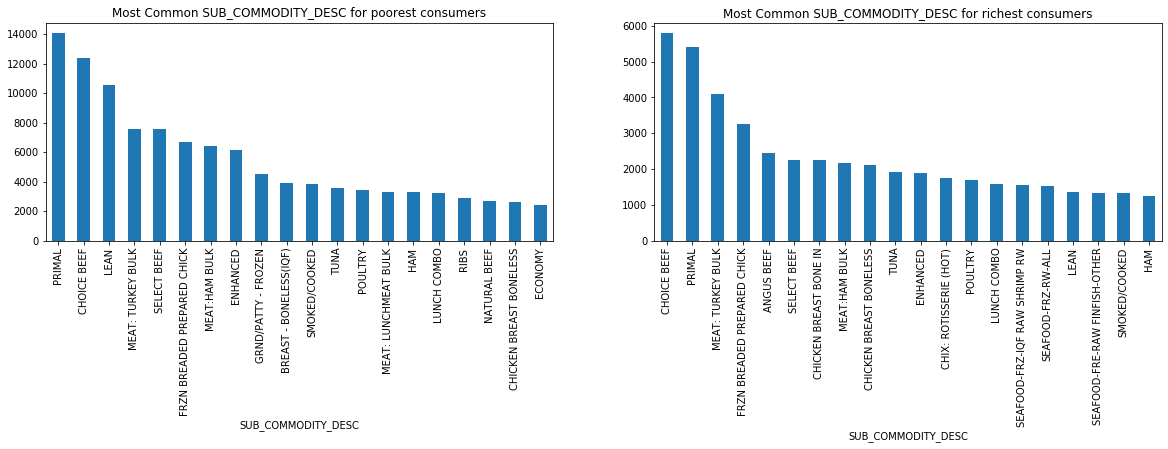

In [113]:
top_20_poor_meat, top_20_rich_meat = compare_two_groups(
    (poor_consumers_meat_transactions, "poorest consumers"),
    (rich_consumers_meat_transactions, "richest consumers"),
    "SUB_COMMODITY_DESC")

For both categories, beef is the most important part of the meat consumption with 4 beef products amongst the 6 first positions. The type of products are quite similar. We can notice that Angus Beef, an expensive meat, makes it into the top 5 products for the wealthiest category.

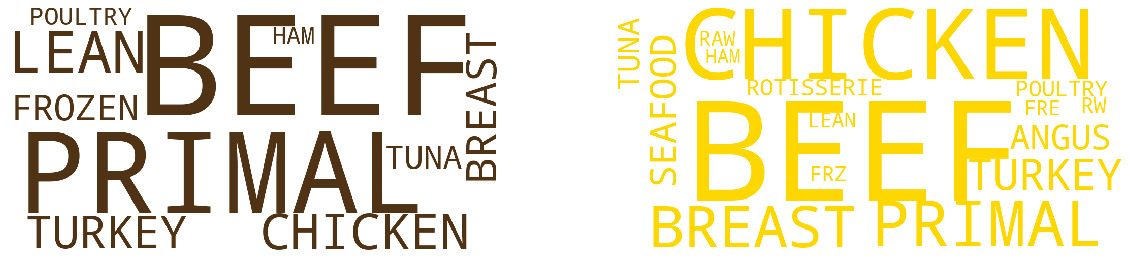

In [114]:
interesting_words = ['PRIMAL', 'BEEF', 'FROZEN', 'BREAST', 'POULTRY', 'PEPPERONI/SALAMI', 'ANGUS', 'ROTISSERIE', 'TURKEY', 'CHICK', 'LEAN', 'HAM', 'BEEF', 'POULTRY', 'CHICKEN', 'TUNA', 'RIBSSEAFOOD-FRZ-IQF', 'SEAFOOD-FRZ-RW-ALL', 'SEAFOOD-FRE-RAW']
plot_word_clouds(interesting_words, top_20_poor_meat, top_20_rich_meat, colors=["rgb(80, 50, 20)", "rgb(255,215,0)"])

From the word cloud, we can see that while the poorest category focusses mainly in beef products, the wealthiest category has a more diverse choice of meats with chicken, turkey and seafood taking main positions.

In [115]:
compare_groups_on_selected_commodidies(poor_consumers_transactions, rich_consumers_transactions, "poorest consumers", "richest consumers", len(poor_houeholds_keys), len(rich_houeholds_keys))

NameError: name 'poor_houeholds_keys' is not defined

We see that the number of transactions are pretty similar for the two categories. The poorest category tends to buy more frozen meat dinners while the wealthiest tend to buy more hispanic and baking products.

## Conclusion

In [ ]:
# TODO: Conclude 3 main parts and answer research questions